# Build Figures

Make all figures in this notebook to keep the results reproducible and the styling consistent.

Created: 2021/04/11
Author:  Andrew Weng

In [1]:
import os, sys

if os.path.basename(os.getcwd()) == 'code':
    os.chdir('../')
sys.path.append('code')

import numpy as np
import pandas as pd
import glob
import pprint
from scipy.stats import pearsonr
from datetime import datetime
from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
import seaborn as sns
from matplotlib import pyplot as plt
import re
from src.formation import FormationCell
from src.utils import get_label_registry

assert os.path.basename(os.getcwd()) == 'project-formation'

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)

## Configure plot settings

In [3]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')


## Configure globals

In [4]:
# Formation types
CELL_BASE = 7
CELL_FAST = 33
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL_CELL = np.array([0, 0, 0])

COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

## Load resources

In [5]:
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    cell_dict[cellid] = FormationCell(cellid)

# Figure 1: Concept Illustration

In [6]:
df_base_form = cell_dict[CELL_BASE].get_formation_data()
df_fast_form = cell_dict[CELL_FAST].get_formation_data()

df_base_form = df_base_form[df_base_form['Test Time (s)'] > 86400]
df_fast_form = df_fast_form[df_fast_form['Test Time (s)'] > 86400]

(-1.0, 65.0)

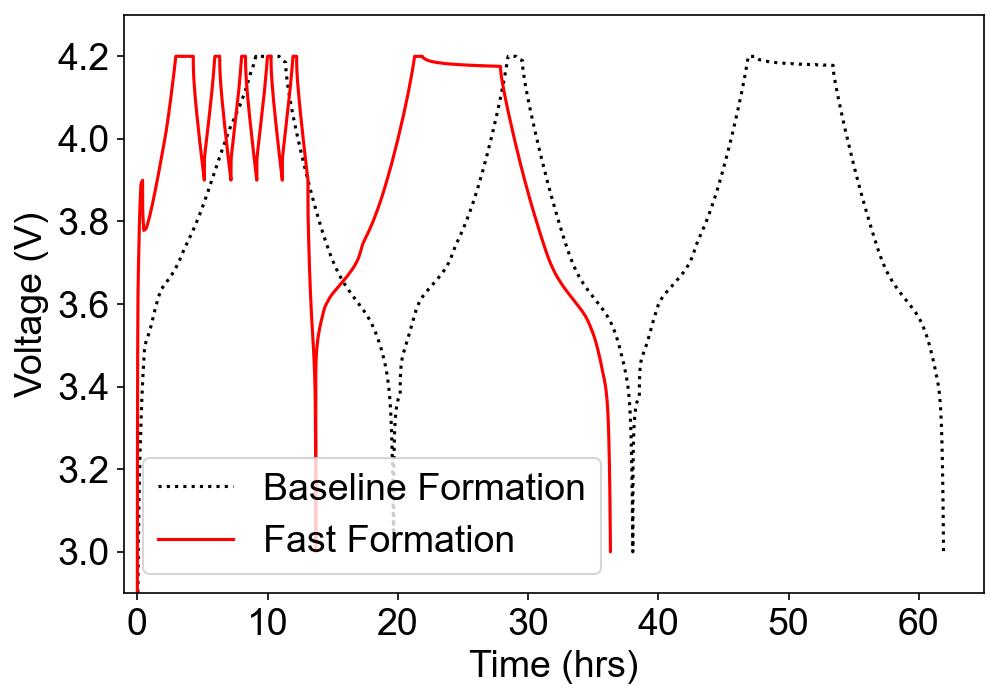

In [7]:
plt.figure()

plt.plot((df_base_form['Test Time (s)'] - 86400)/3600, df_base_form['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_form['Test Time (s)'] - 86400)/3600, df_fast_form['Potential (V)'], 
         color=COLOR_FAST_HT, linestyle=LINESTYLE_FAST)
plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline Formation', 'Fast Formation'], frameon=True)
plt.ylim((2.9, 4.3))
plt.xlim((-1, 65))


In [8]:
df_base_rpt = cell_dict[CELL_BASE].get_aging_data_timeseries()
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] < 5]
df_base_rpt = df_base_rpt[df_base_rpt['Cycle Number'] > 1]

df_fast_rpt = cell_dict[CELL_FAST].get_aging_data_timeseries()
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] < 5]
df_fast_rpt = df_fast_rpt[df_fast_rpt['Cycle Number'] > 1]

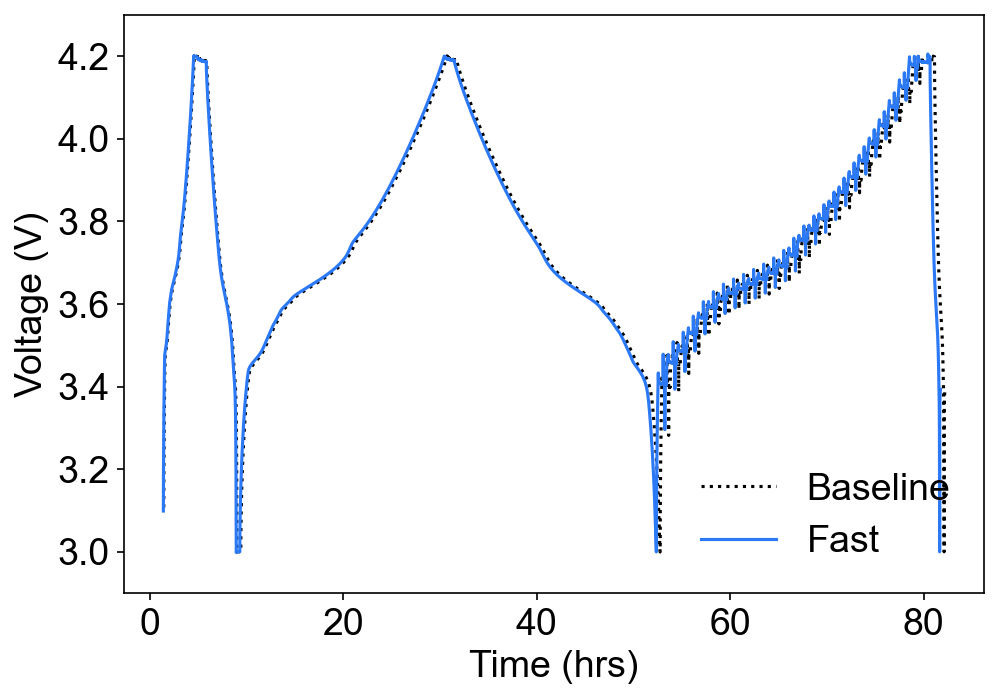

In [9]:
plt.subplot()

plt.plot(df_base_rpt['Test Time (s)'] / 3600, df_base_rpt['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_rpt['Test Time (s)'] / 3600, df_fast_rpt['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
plt.ylim((2.9, 4.3))
plt.legend(['Baseline', 'Fast'], frameon=False)

In [10]:
df_base_cyc = cell_dict[CELL_BASE].get_aging_data_cycles()

idx = np.where((df_base_cyc['Total Charge Time (s)'] > 8500) |
               (df_base_cyc['Total Charge Time (s)'] < 100))[0]

df_base_cyc['Discharge Capacity (Ah)'][idx] = np.nan

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [11]:
df_fast_cyc = cell_dict[CELL_FAST].get_aging_data_cycles()

idx = np.where((df_fast_cyc['Total Charge Time (s)'] > 8500) |
               (df_fast_cyc['Total Charge Time (s)'] < 100))[0]

df_fast_cyc['Discharge Capacity (Ah)'][idx] = np.nan

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(0.0, 500.0)

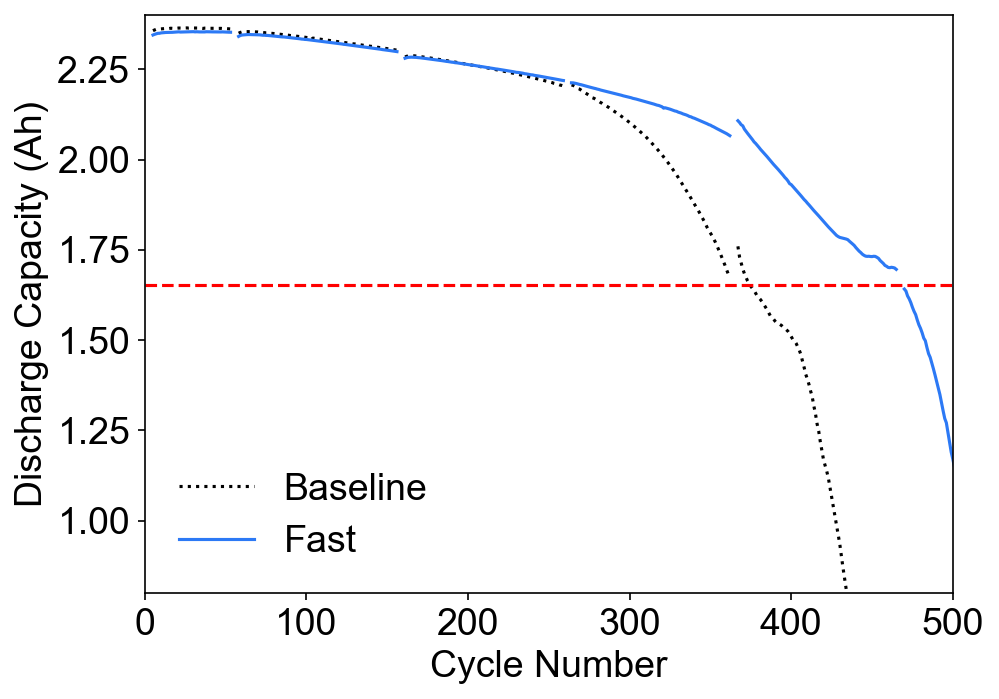

In [12]:
plt.figure()

plt.plot(df_base_cyc['Cycle Number'], df_base_cyc['Discharge Capacity (Ah)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(df_fast_cyc['Cycle Number'], df_fast_cyc['Discharge Capacity (Ah)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH , color='r', linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim(CAPACITY_LIMITS_AH)
plt.xlim((0, 500))

<ipython-input-13-c4a4451f2460>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base_deltav['Test Time (s)'] -= np.min(df_base_deltav['Test Time (s)'])
<ipython-input-13-c4a4451f2460>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fast_deltav['Test Time (s)'] -= np.min(df_fast_deltav['Test Time (s)'])


(0.0, 6.7)

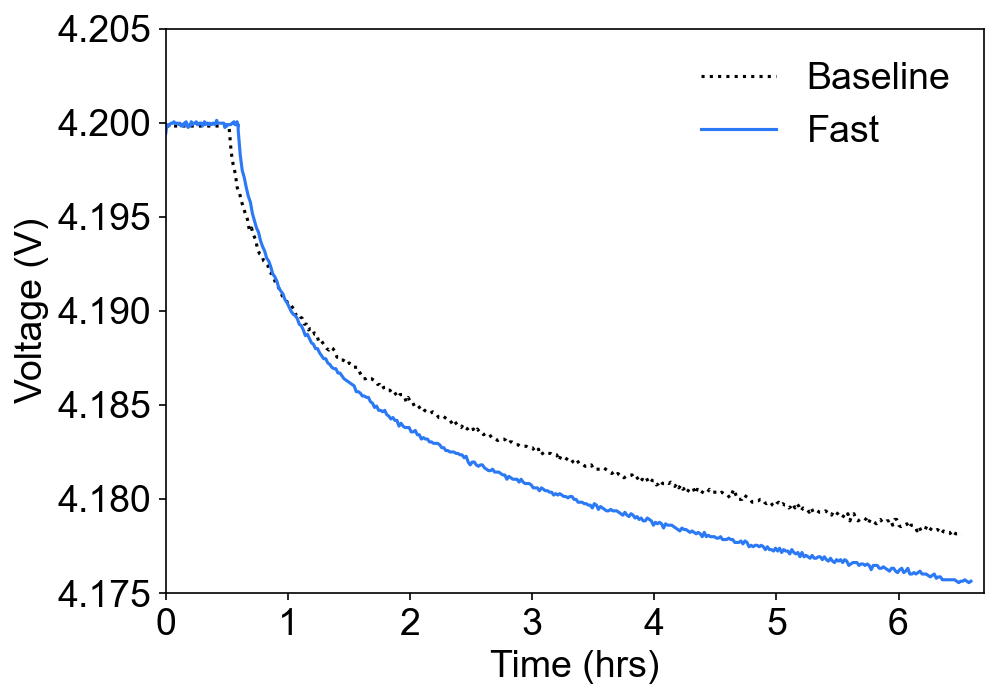

In [13]:
# Process voltage decay signal during 12-hour rest step
STEP_INDEX_6HR_REST = 12
CYCLE_INDEX_6HR_REST = 3
VOLTAGE_MAXIMUM = 4.2

df_base_deltav = df_base_form[(df_base_form['Cycle Number'] == 3) &
                              (
                                  (df_base_form['Step Index'] == 11) | 
                                  (df_base_form['Step Index'] == 12)
                              )]

df_base_deltav['Test Time (s)'] -= np.min(df_base_deltav['Test Time (s)'])

df_fast_deltav = df_fast_form[(df_fast_form['Cycle Number'] == 7) &
                              (
                                  (df_fast_form['Step Index'] == 13) | 
                                  (df_fast_form['Step Index'] == 12)
                              )]

df_fast_deltav['Test Time (s)'] -= np.min(df_fast_deltav['Test Time (s)'])

plt.figure()

plt.plot((df_base_deltav['Test Time (s)'])/3600, df_base_deltav['Potential (V)'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot((df_fast_deltav['Test Time (s)'])/3600, df_fast_deltav['Potential (V)'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST)

plt.xlabel('Time (hrs)')
plt.ylabel('Voltage (V)')
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)
plt.ylim((4.175, 4.205))
plt.xlim((0, 6.7))

In [14]:
hppc_base_list = cell_dict[CELL_BASE].process_diagnostic_hppc_data()
# Unpack data from first available cycle
df_hppc_base = hppc_base_list[0]['data']

hppc_fast_list = cell_dict[CELL_FAST].process_diagnostic_hppc_data()
# Unpack data from first available cycle
df_hppc_fast = hppc_fast_list[0]['data']

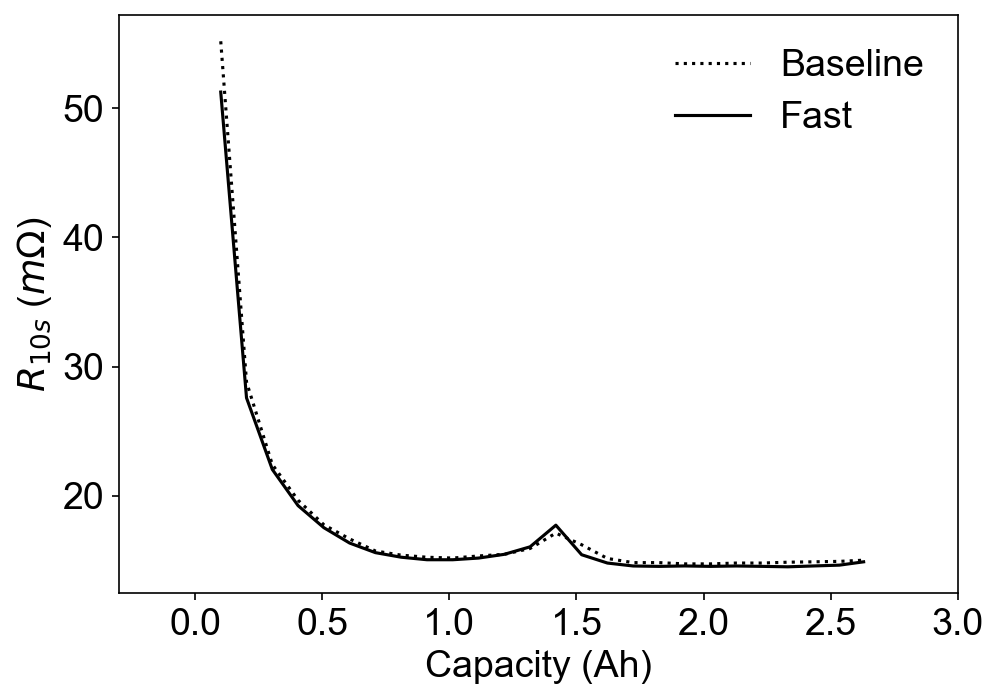

In [15]:
plt.figure()

plt.plot(df_hppc_base['capacity'],
         df_hppc_base['resistance_10s_ohm']*1000, 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE)

plt.plot(df_hppc_fast['capacity'],
         df_hppc_fast['resistance_10s_ohm']*1000, 
         color='k', linestyle=LINESTYLE_FAST)
         
plt.xlabel('Capacity (Ah)')
plt.ylabel('$R_{10s}$ ($m\Omega$)')
plt.xlim((-0.3, 3))
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)

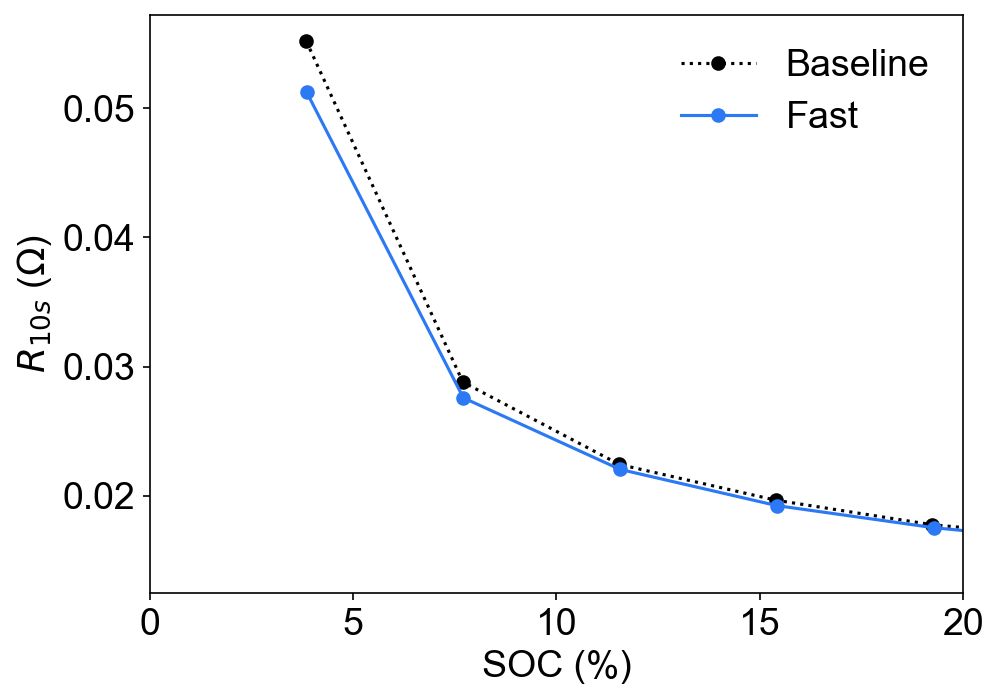

In [16]:
plt.figure()

plt.plot(df_hppc_base['capacity']/np.max(df_hppc_base['capacity'])*100,
         df_hppc_base['resistance_10s_ohm'], 
         color=COLOR_BASE, linestyle=LINESTYLE_BASE, marker='o')

plt.plot(df_hppc_fast['capacity']/np.max(df_hppc_fast['capacity'])*100,
         df_hppc_fast['resistance_10s_ohm'], 
         color=COLOR_FAST, linestyle=LINESTYLE_FAST, marker='o')
         
plt.xlabel('SOC (%)')
plt.ylabel('$R_{10s}$ ($\Omega$)')
plt.xlim((0, 20))
lgd = plt.legend(['Baseline', 'Fast'], frameon=False)

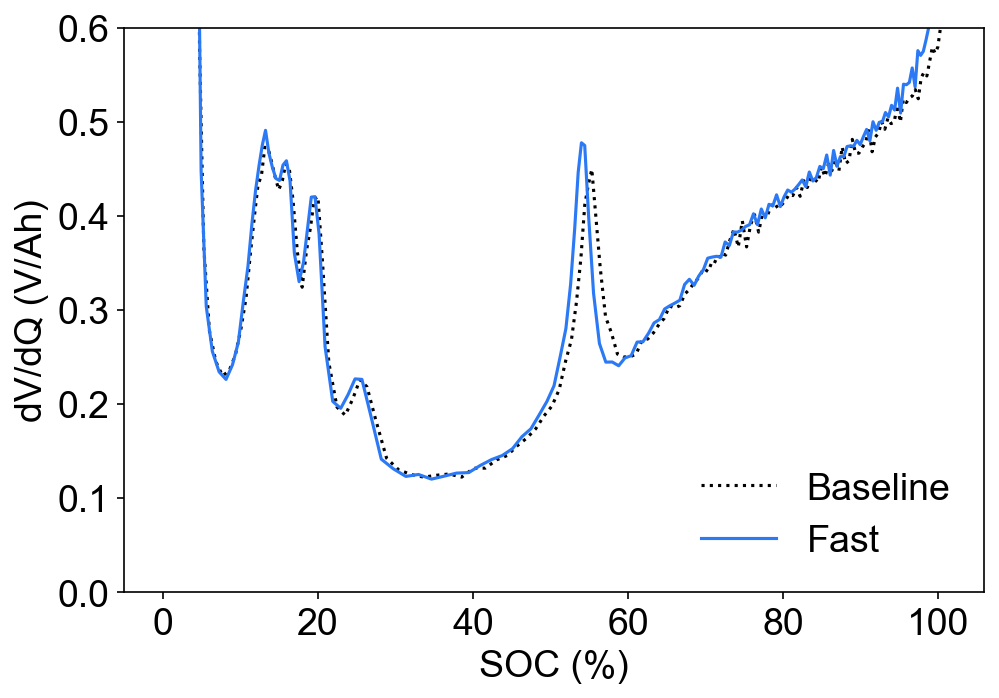

In [17]:
c20_base_list = cell_dict[CELL_BASE].process_diagnostic_c20_data()
c20_fast_list = cell_dict[CELL_FAST].process_diagnostic_c20_data()

df_c20_base = c20_base_list[0]
df_c20_fast = c20_fast_list[0]

plt.figure()
plt.plot(df_c20_base['chg_capacity']/np.max(df_c20_fast['chg_capacity'])*100, 
         df_c20_base['chg_dvdq'], linestyle=LINESTYLE_BASE, color=COLOR_BASE)

plt.plot(df_c20_fast['chg_capacity']/np.max(df_c20_fast['chg_capacity'])*100, 
         df_c20_fast['chg_dvdq'], linestyle=LINESTYLE_FAST, color=COLOR_FAST)

plt.ylim((0, 0.6))
plt.xlabel('SOC (%)')
plt.ylabel('dV/dQ (V/Ah)')
plt.legend(['Baseline', 'Fast'], frameon=False)

# Figure 2: Main Correlation Results

<ipython-input-18-a5581eb50592>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Discharge Capacity (Ah)'][idx] = np.nan
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-18-a5581eb50592>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Discharge Capacity (Ah)'][idx] = n

<ipython-input-18-a5581eb50592>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Discharge Capacity (Ah)'][idx] = np.nan
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-18-a5581eb50592>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Discharge Capacity (Ah)'][idx] = n

(0.8, 2.4)

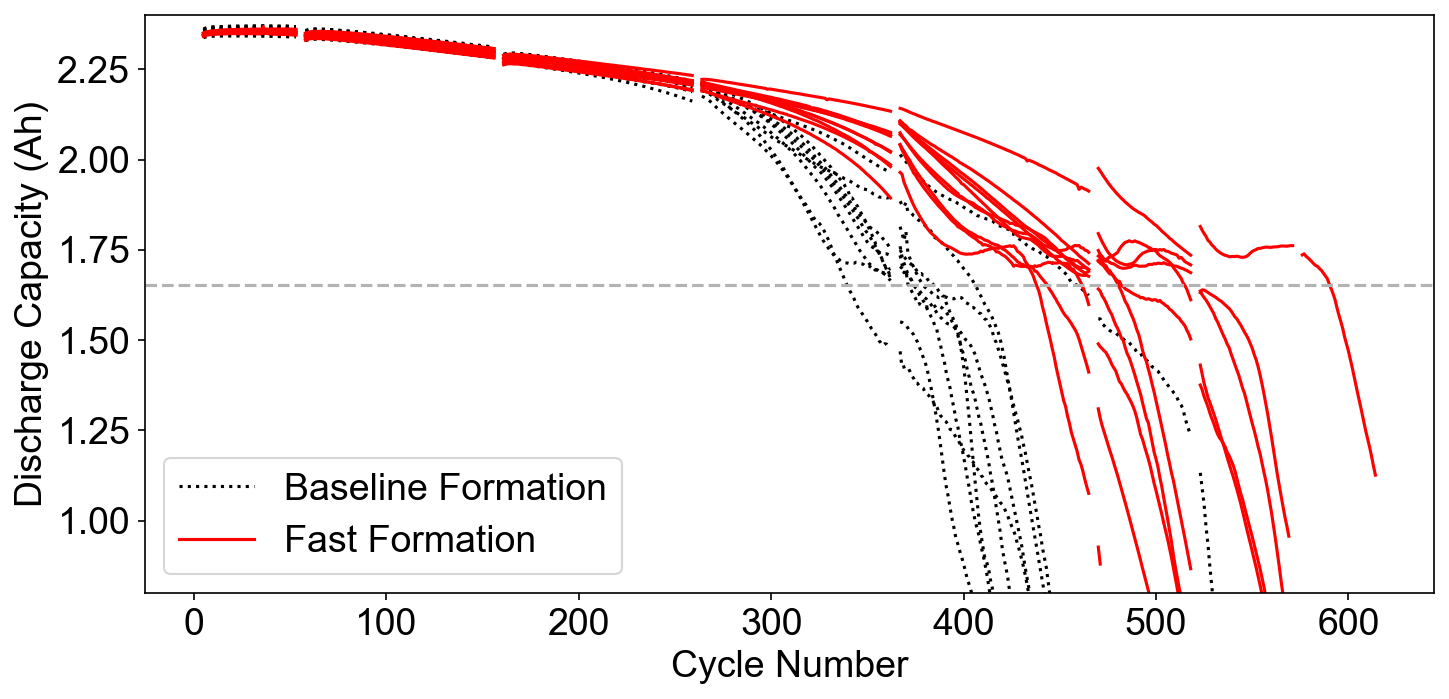

In [18]:
cellid_list = np.arange(1, 41)

plt.figure(figsize=(10, 5))

for cellid in cellid_list:
    cell = FormationCell(cellid)
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_HT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df = df.copy()
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)
    
plt.plot(np.nan, np.nan, label='Baseline Formation',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast Formation',
        color=COLOR_FAST_HT, linestyle=LINESTYLE_FAST)
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
        color=COLOR_REF, linestyle='--')
plt.legend()
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https:

(0.8, 2.4)

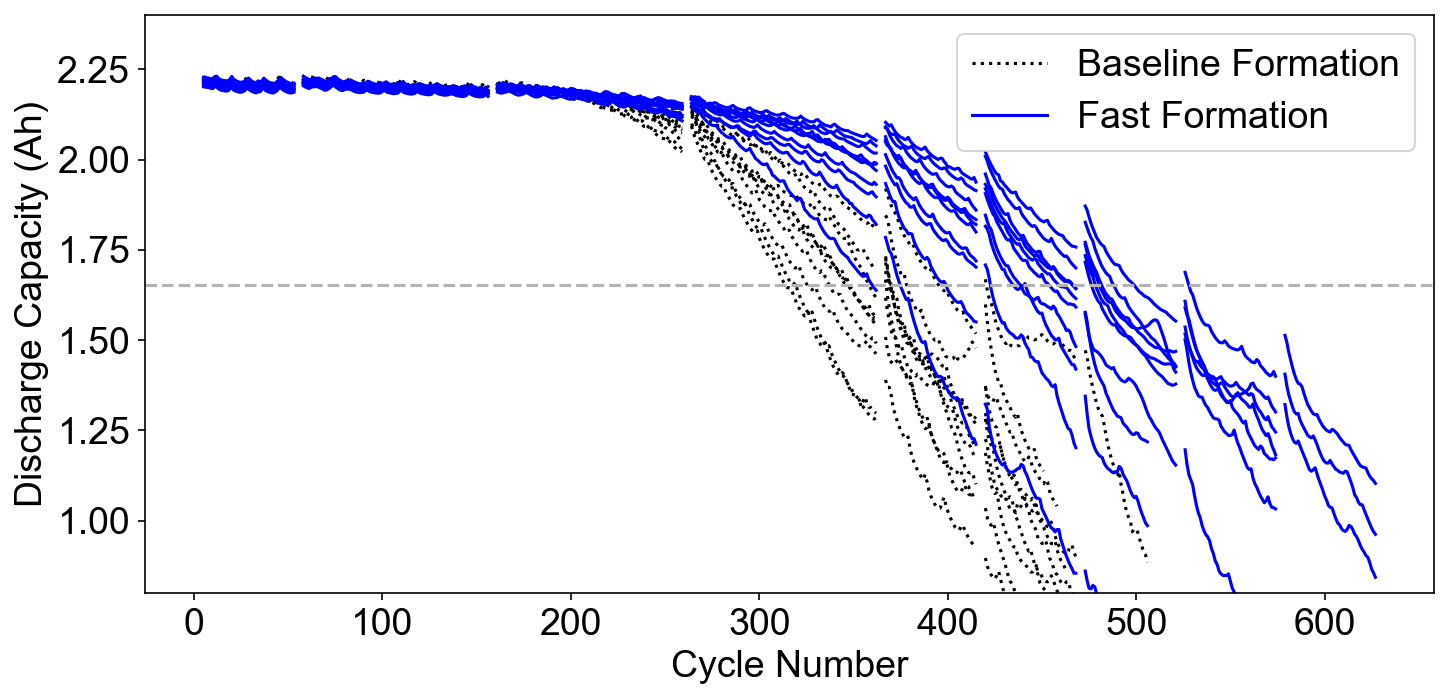

In [19]:
plt.figure(figsize=(10, 5))

for cellid in cellid_list:
    cell = FormationCell(cellid)
    
    if not cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
        linestyle = LINESTYLE_BASE
    else:
        color = COLOR_FAST_RT
        linestyle = LINESTYLE_FAST
        
    df = cell.get_aging_data_cycles()
    
    idx = np.where((df['Total Charge Time (s)'] > 8500) |
                   (df['Total Charge Time (s)'] < 100))[0]
    df['Discharge Capacity (Ah)'][idx] = np.nan
    
    cyc = df['Cycle Number']
    cap = df['Discharge Capacity (Ah)']
    
    plt.plot(cyc, cap, 
             color=color, linestyle=linestyle)

plt.plot(np.nan, np.nan, label='Baseline Formation',
        color=COLOR_BASE, linestyle=LINESTYLE_BASE)
plt.plot(np.nan, np.nan, label='Fast Formation',
        color=COLOR_FAST_RT, linestyle=LINESTYLE_FAST)
plt.legend()    
plt.axhline(y=TARGET_RETENTION*NOMINAL_CAPACITY_AH, 
            color=COLOR_REF, linestyle='--')
plt.xlabel('Cycle Number')
plt.ylabel('Discharge Capacity (Ah)')
plt.ylim(CAPACITY_LIMITS_AH)

### Plot the correlations

In [20]:
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (4.5, 4.5),
                    'facecolor'  : 'white',
                    'dpi'        : 100
                    })

In [21]:
path = 'output/2021-03-fast-formation-esoh-fits/correlation_data.csv';

df = pd.read_csv(path)

for col in sorted(df.columns):
    print(col)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

In [22]:
group1 = df[(df['is_baseline_formation'] == True) & (df['is_room_temp_aging'] == False)]['cycles_to_50_pct']
group2 = df[(df['is_baseline_formation'] == False) & (df['is_room_temp_aging'] == False)]['cycles_to_50_pct']

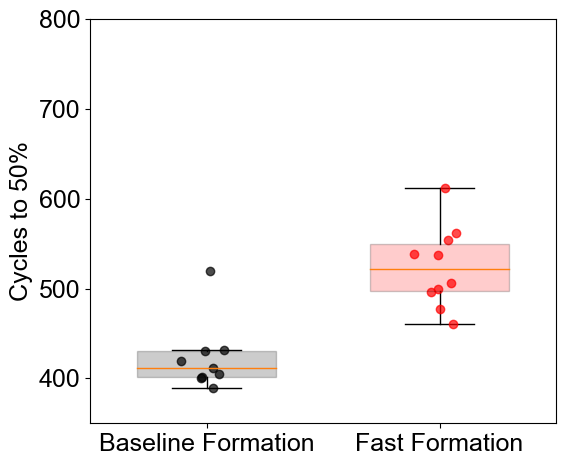

In [23]:
all_data = [group1, group2]
labels = ['Baseline Formation', 'Fast Formation']

fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

# rectangular box plot
bplot = ax1.boxplot(all_data,
                    vert=True,  # vertical box alignment
                    patch_artist=True,  # fill with color
                    labels=labels,
                    showfliers=False,
                    widths=0.6)  # will be used to label x-ticks

x = np.random.normal(1, 0.04, size=len(all_data[0]))
plt.plot(x, all_data[0], marker='o', linestyle='', color=COLOR_BASE, alpha=0.7)

x = np.random.normal(2, 0.04, size=len(all_data[1]))
plt.plot(x, all_data[1], marker='o', linestyle='', color=COLOR_FAST_HT, alpha=0.7)

# fill with colors
colors = [COLOR_BASE, COLOR_FAST_HT]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.2)
  
# adding horizontal grid lines
for ax in [ax1]:
    ax.yaxis.grid(False)
    ax.set_ylabel('Cycles to 50%')

plt.ylim((350, 800))
plt.show()


Automatic pdb calling has been turned ON


<ipython-input-24-53ff3ea05964>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan
<ipython-input-24-53ff3ea05964>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan
<ipython-input-24-53ff3ea05964>:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


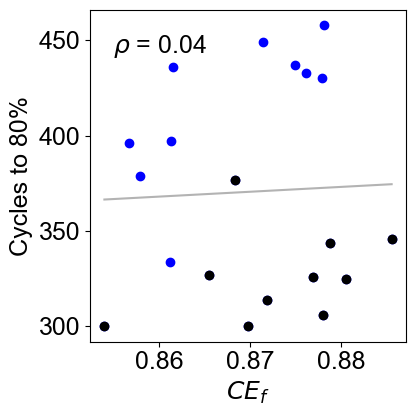

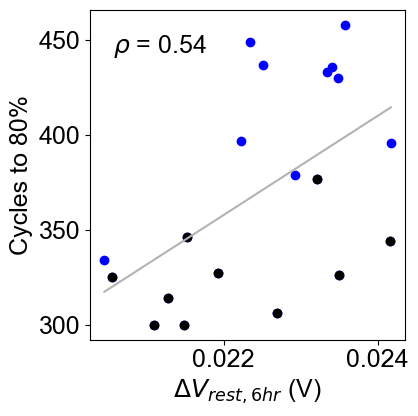

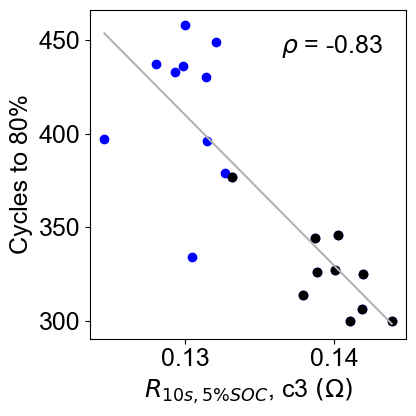

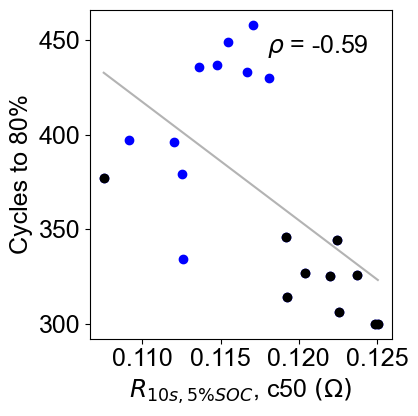

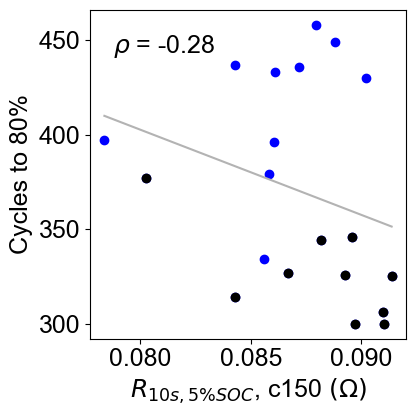

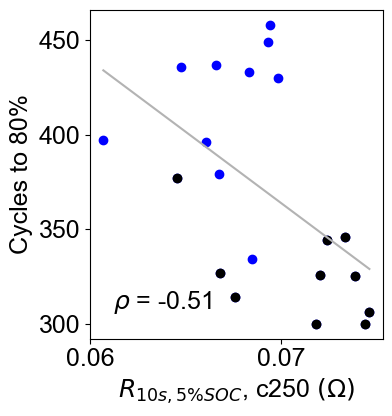

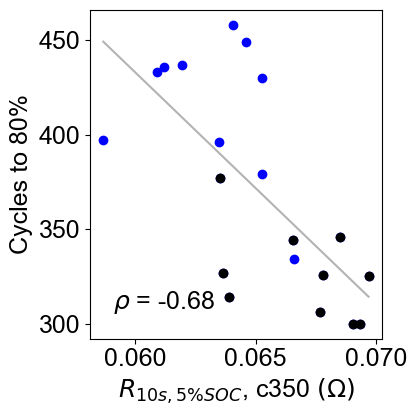

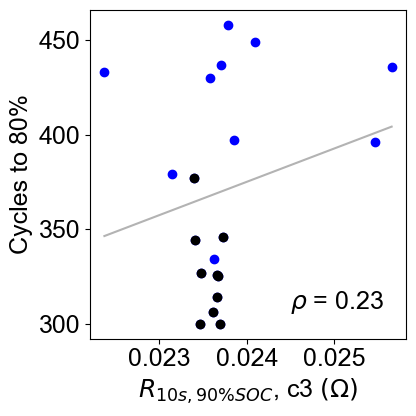

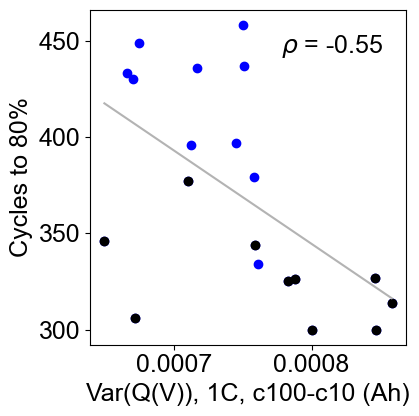

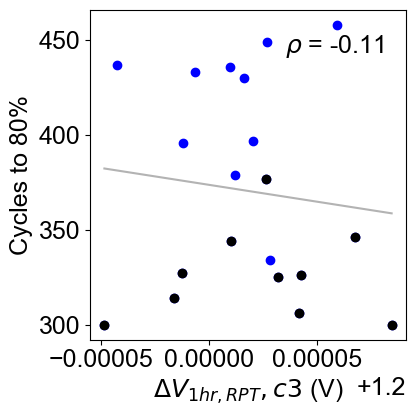

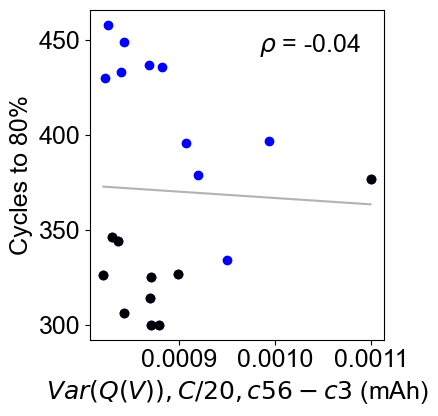

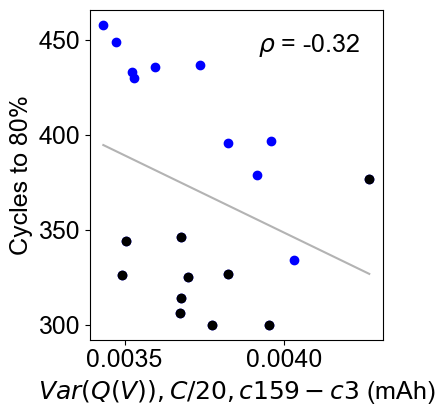

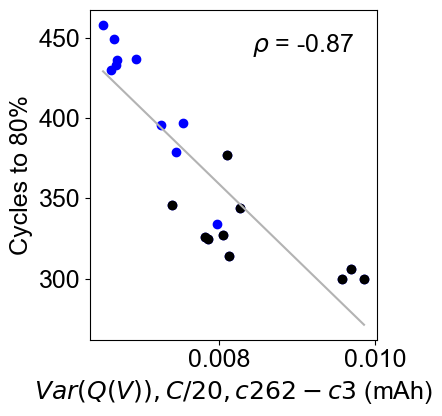

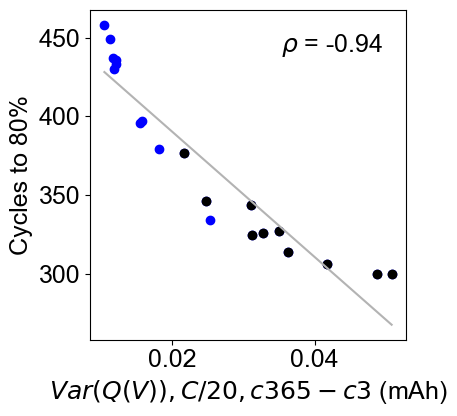

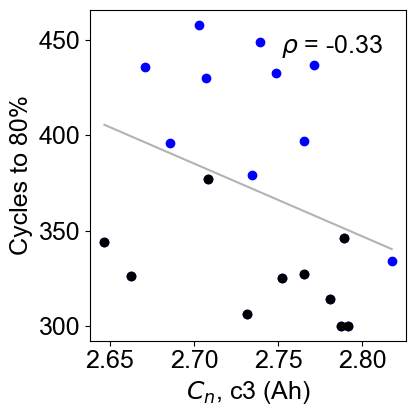

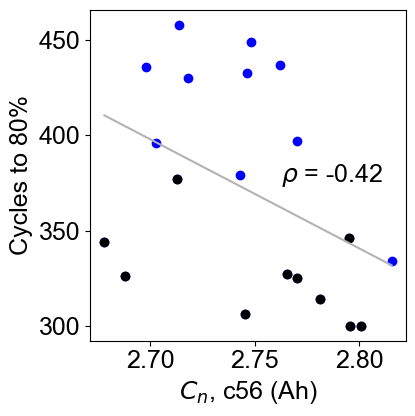

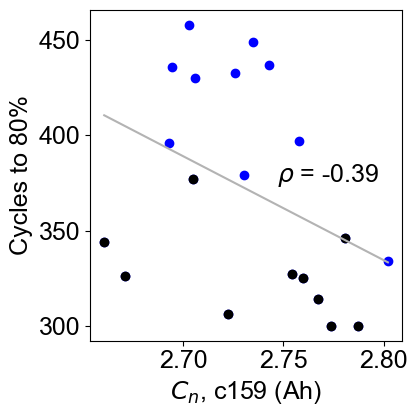

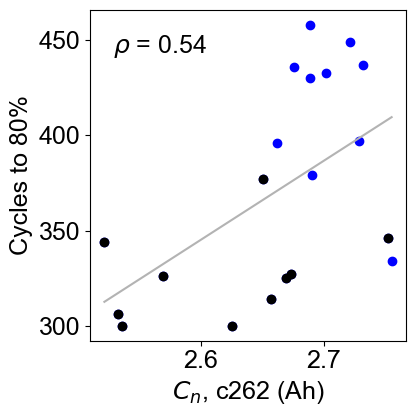

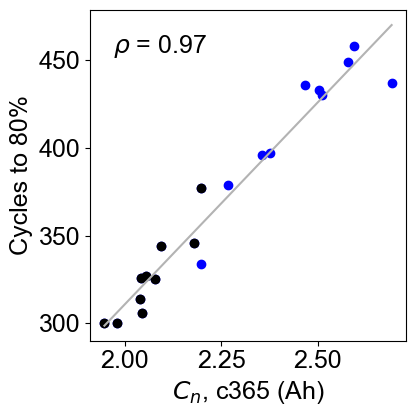

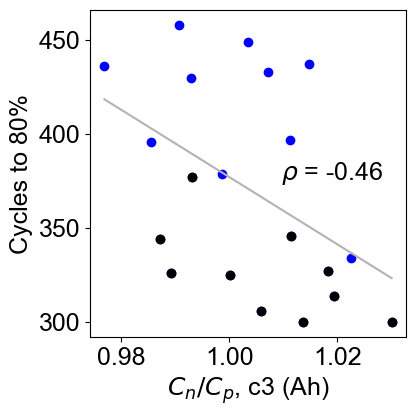

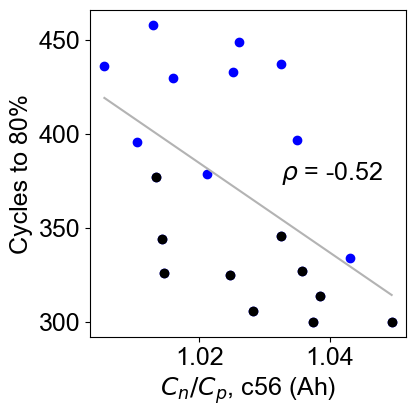

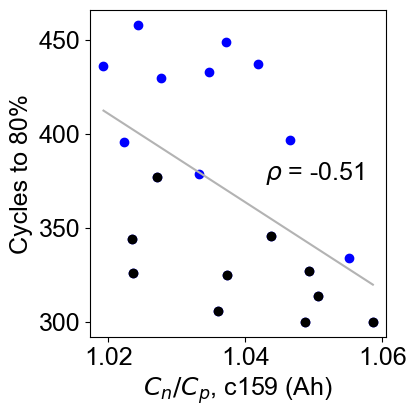

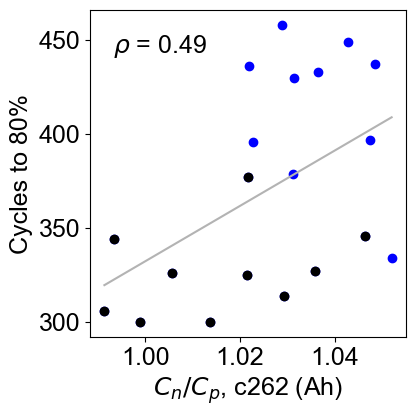

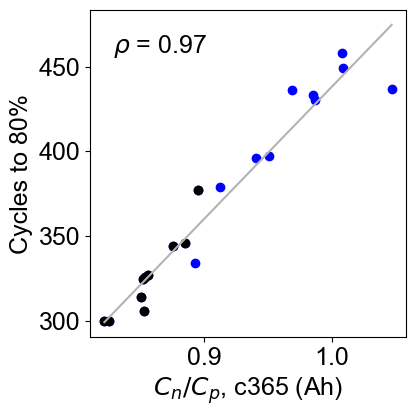

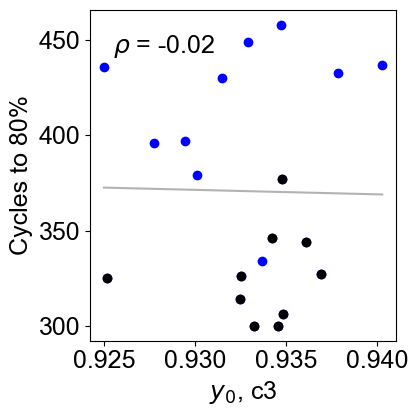

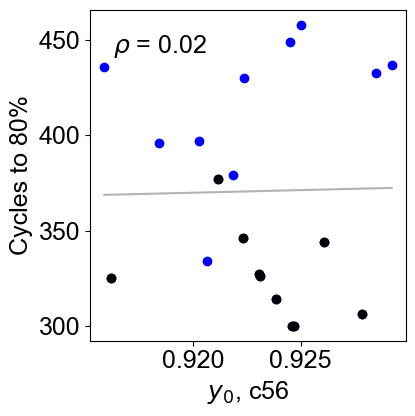

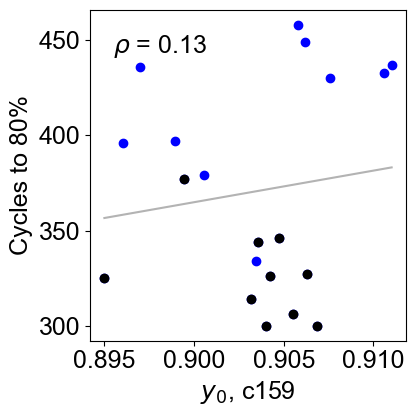

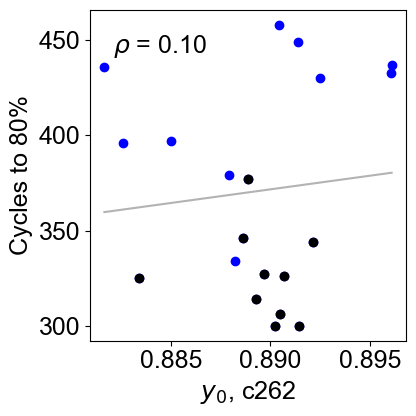

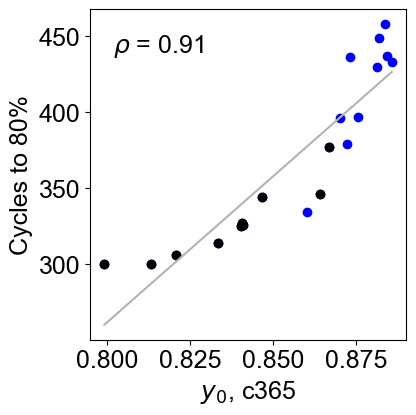

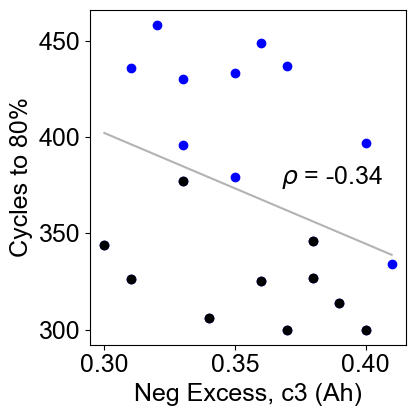

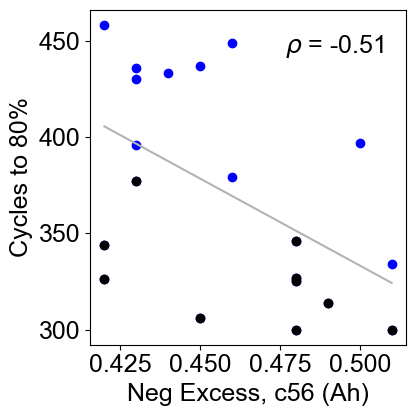

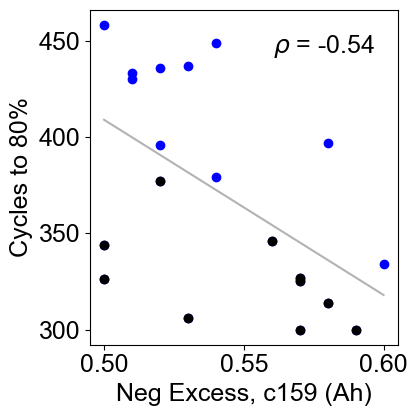

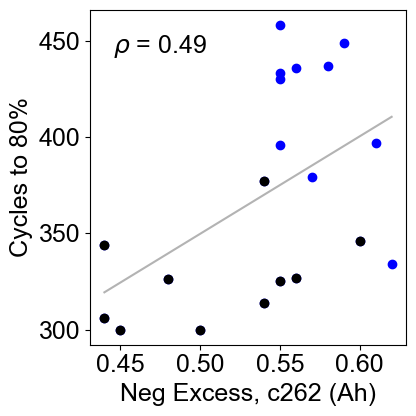

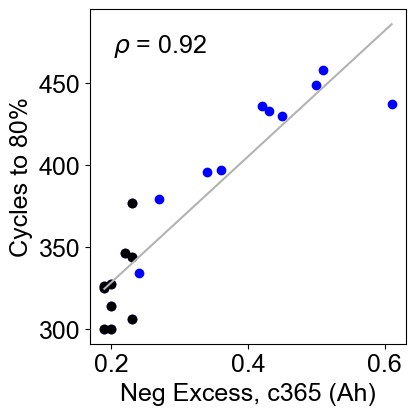

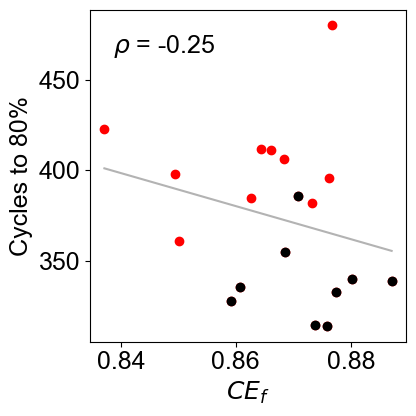

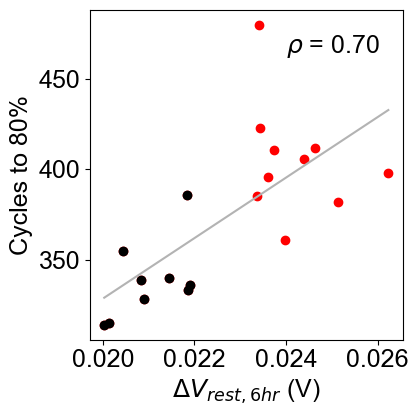

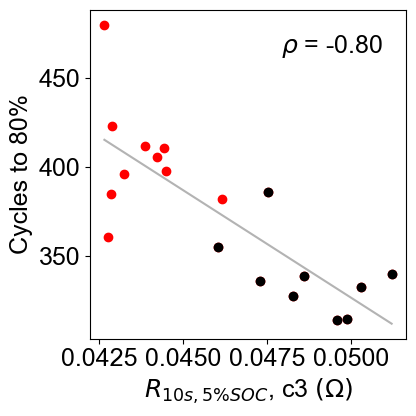

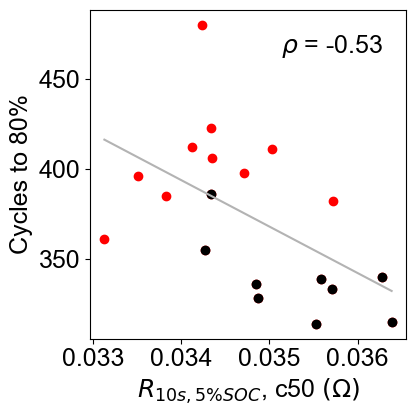

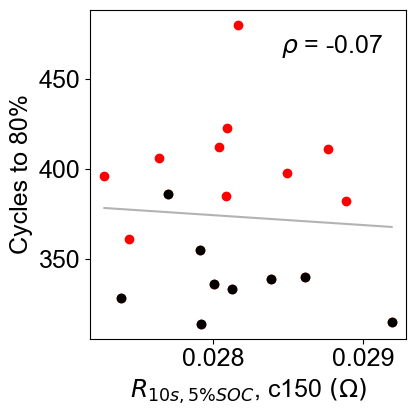

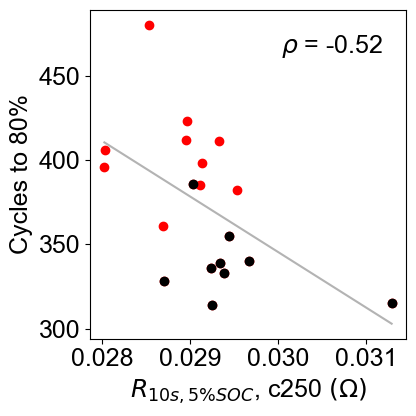

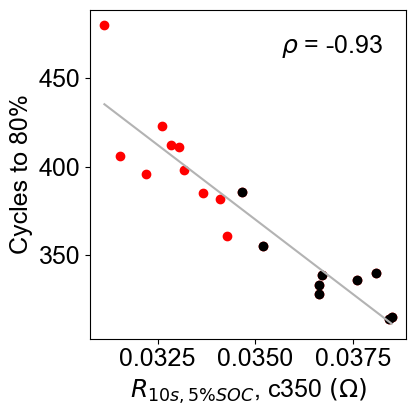

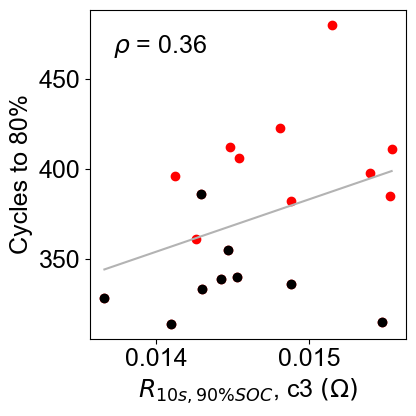

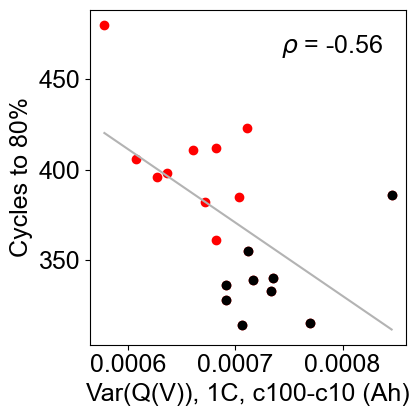

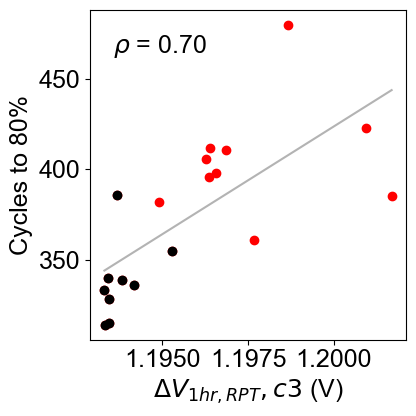

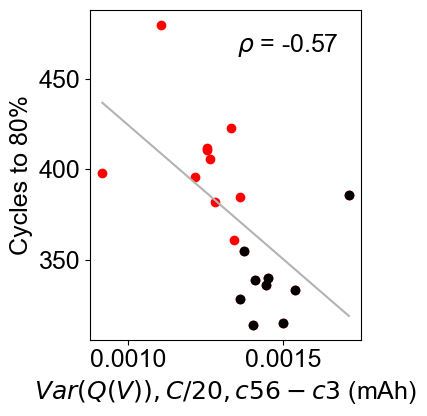

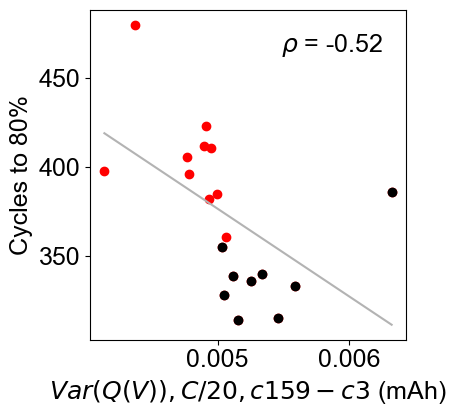

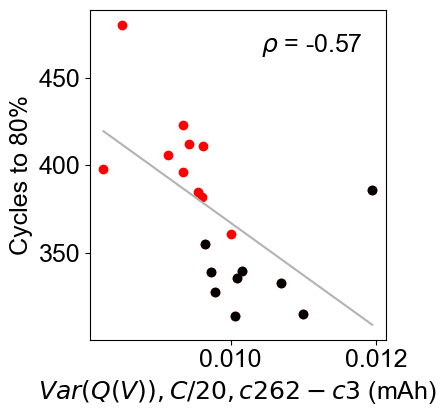

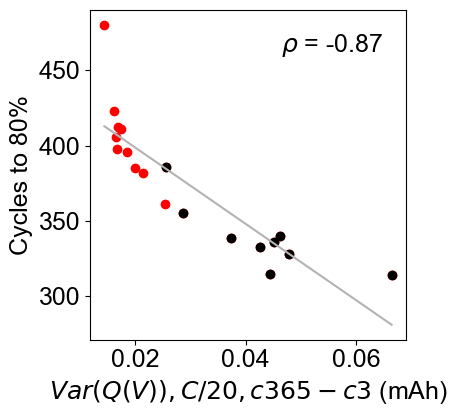

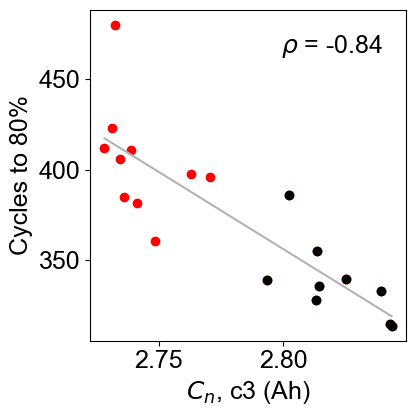

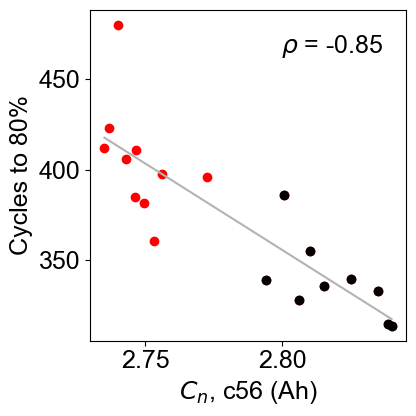

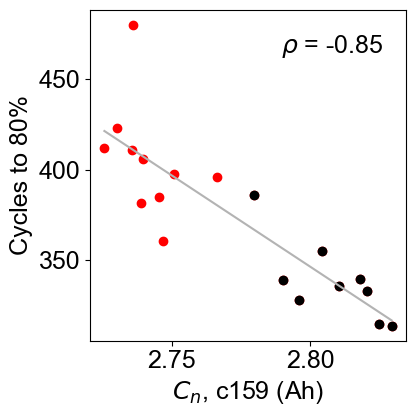

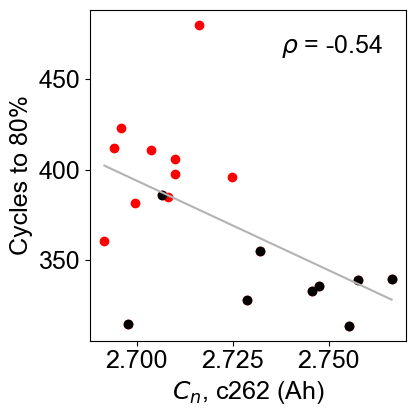

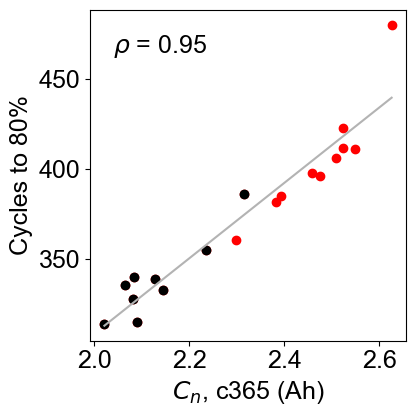

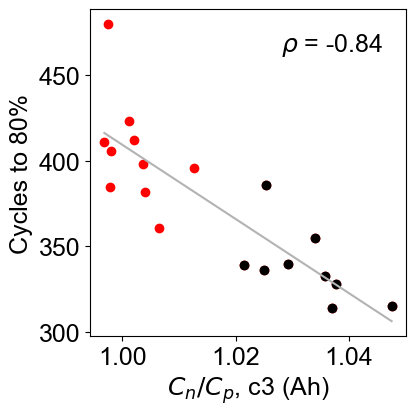

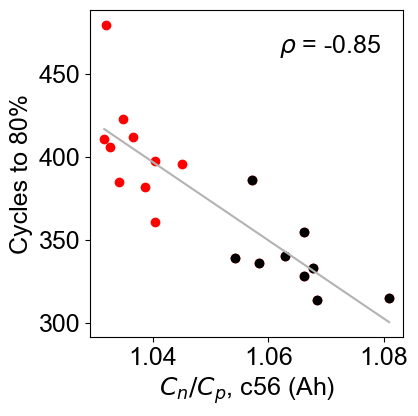

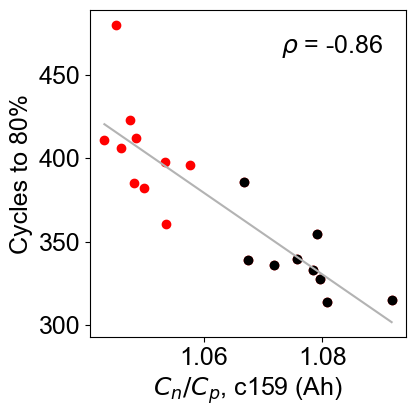

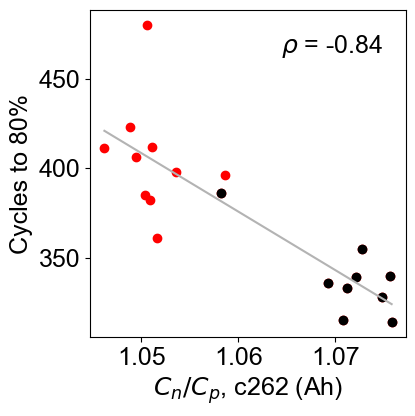

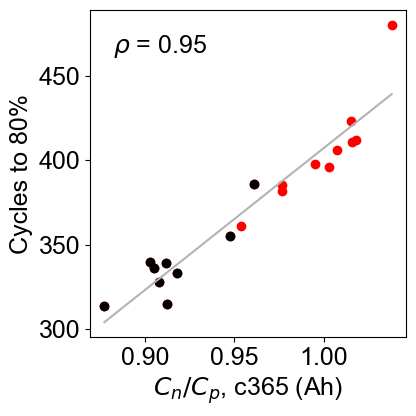

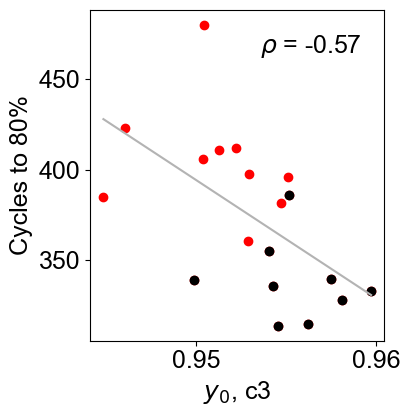

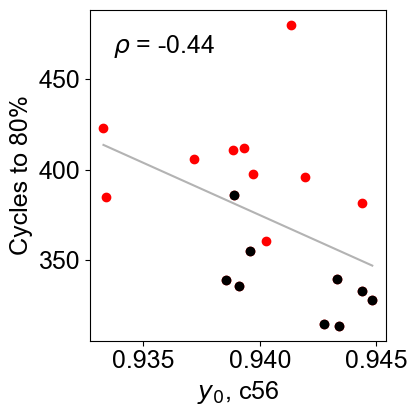

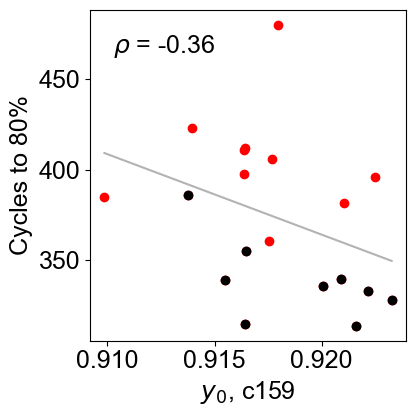

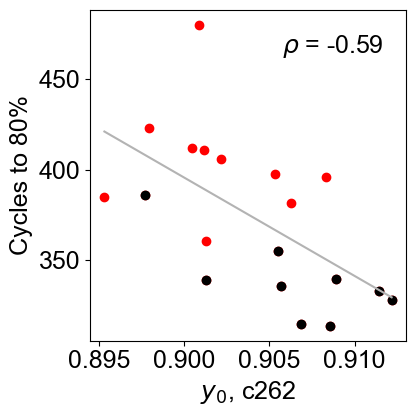

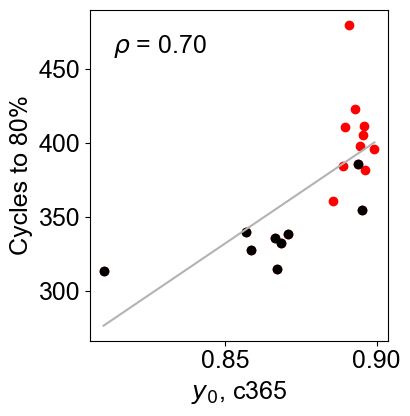

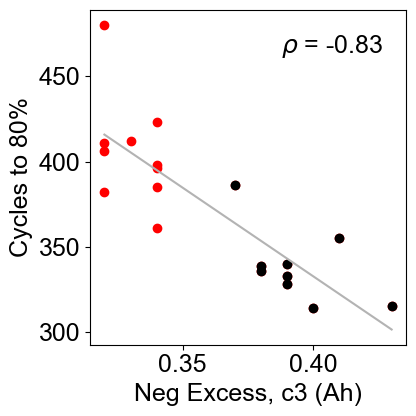

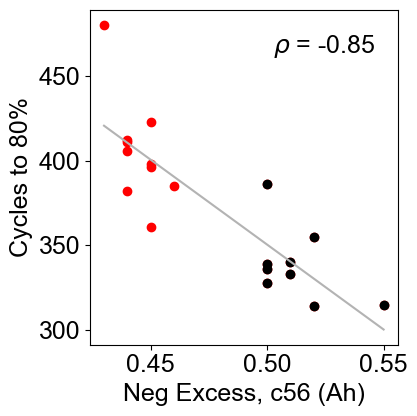

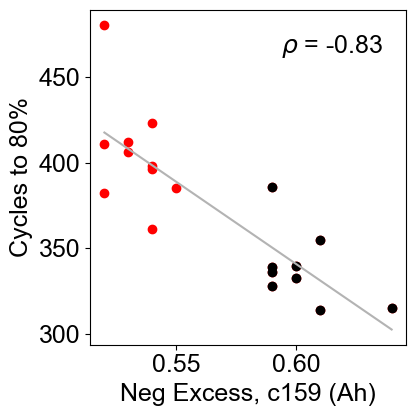

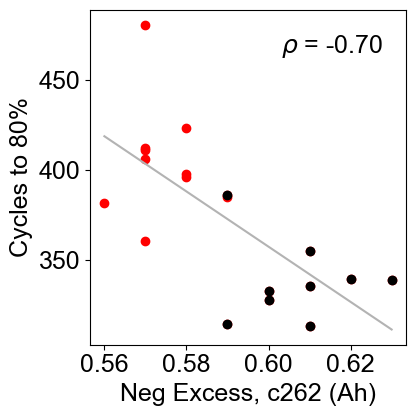

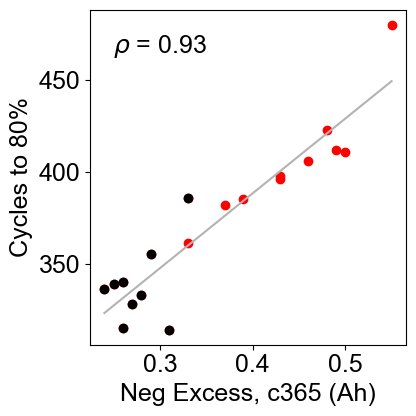

In [24]:
label_registry = get_label_registry()

%pdb
cyc_idx_rpt_arr = [3, 56, 159, 262, 365]

df = df[df['cellid'] != 9]

df['esoh_c3_Cn'][df['esoh_c3_Cn'] > 3] = np.nan 
df['esoh_c3_CnCp'][df['esoh_c3_CnCp'] > 1.2] = np.nan
df_rt = df[df['is_room_temp_aging'] == 1]
df_ht = df[df['is_room_temp_aging'] == 0]

xvar_array = ['form_coulombic_efficiency',
              'form_6hr_rest_delta_voltage_v',
              'dcr_10s_5_soc_at_c3', 
              'dcr_10s_5_soc_at_c50', 
              'dcr_10s_5_soc_at_c150', 
              'dcr_10s_5_soc_at_c250', 
              'dcr_10s_5_soc_at_c350',
              'dcr_10s_90_soc_at_c3',
              'var_q_1c_c100_c10_ah',
              'rpt_c3_delta_v']

[xvar_array.append(f'var_q_c20_c{x}_c3_ah') for x in cyc_idx_rpt_arr[1::] ]
[xvar_array.append(f'esoh_c{x}_Cn') for x in cyc_idx_rpt_arr ]
[xvar_array.append(f'esoh_c{x}_CnCp') for x in cyc_idx_rpt_arr ]
[xvar_array.append(f'esoh_c{x}_y0') for x in cyc_idx_rpt_arr ]
[xvar_array.append(f'esoh_c{x}_neg_excess') for x in cyc_idx_rpt_arr ]


yvar = 'cycles_to_80_pct'

df_array = [df_rt, df_ht]
color_fast_array = [COLOR_FAST_RT, COLOR_FAST_HT]

# Loop over temperatures
for df, color_fast in zip(df_array, color_fast_array): 
    
    # Loop over x-variables
    for xvar in xvar_array:

        model = LinearRegression()

        x = df[xvar].values
        y = df[yvar].values
        idx_to_keep = ~np.isnan(x)
        x = x[idx_to_keep]
        y = y[idx_to_keep]

        corr, _ = pearsonr(x, y)
        model.fit(x.reshape(-1, 1), y)
        x_fit = np.linspace(np.min(x), np.max(x), 100)
        y_fit = model.predict(x_fit.reshape(-1, 1))
        
        idx_base = np.where(df['is_baseline_formation'])[0]
        idx_fast = np.where(~df['is_baseline_formation'])[0]

        plt.figure()

        plt.plot(df[xvar].iloc[idx_fast], df[yvar].iloc[idx_fast], 
                 linestyle='None', marker='o',
                 color=color_fast, label='')

        plt.plot(df[xvar].iloc[idx_base], df[yvar].iloc[idx_base], 
                 linestyle='None', marker='o',
                 color=COLOR_BASE, label='')

#         if corr**2 > 0.5:
        plt.plot(x_fit, y_fit, color=COLOR_REF, label='')
        plt.plot(np.nan, np.nan, label=rf'$\rho$ = {corr:.2f}',
                     marker='None', linestyle='None')

        leg = plt.legend(frameon=False,
                             handletextpad=0, handlelength=0)

#         plt.xlim(label_registry[xvar][1])
        plt.xlim((None, None))
        plt.xlabel(label_registry[xvar][0])
        plt.ylabel(label_registry[yvar][0])


In [25]:
# These are the available variables for plotting
for key in sorted(df.keys()):
    print(key)

Unnamed: 0
cellid
channel_number
cycles_to_50_pct
cycles_to_60_pct
cycles_to_70_pct
cycles_to_80_pct
dcr_10s_0_soc_at_c100
dcr_10s_0_soc_at_c150
dcr_10s_0_soc_at_c159
dcr_10s_0_soc_at_c200
dcr_10s_0_soc_at_c250
dcr_10s_0_soc_at_c262
dcr_10s_0_soc_at_c3
dcr_10s_0_soc_at_c300
dcr_10s_0_soc_at_c350
dcr_10s_0_soc_at_c365
dcr_10s_0_soc_at_c400
dcr_10s_0_soc_at_c450
dcr_10s_0_soc_at_c50
dcr_10s_0_soc_at_c56
dcr_10s_100_soc_at_c100
dcr_10s_100_soc_at_c150
dcr_10s_100_soc_at_c159
dcr_10s_100_soc_at_c200
dcr_10s_100_soc_at_c250
dcr_10s_100_soc_at_c262
dcr_10s_100_soc_at_c3
dcr_10s_100_soc_at_c300
dcr_10s_100_soc_at_c350
dcr_10s_100_soc_at_c365
dcr_10s_100_soc_at_c400
dcr_10s_100_soc_at_c450
dcr_10s_100_soc_at_c50
dcr_10s_100_soc_at_c56
dcr_10s_10_soc_at_c100
dcr_10s_10_soc_at_c150
dcr_10s_10_soc_at_c159
dcr_10s_10_soc_at_c200
dcr_10s_10_soc_at_c250
dcr_10s_10_soc_at_c262
dcr_10s_10_soc_at_c3
dcr_10s_10_soc_at_c300
dcr_10s_10_soc_at_c350
dcr_10s_10_soc_at_c365
dcr_10s_10_soc_at_c400
dcr_10s_10_s

# Figure 3: Explanation of $C_n$ effect on Low-SOC Resistance

Plot the evolution of x_0, x_100, y_0, y_100 over time

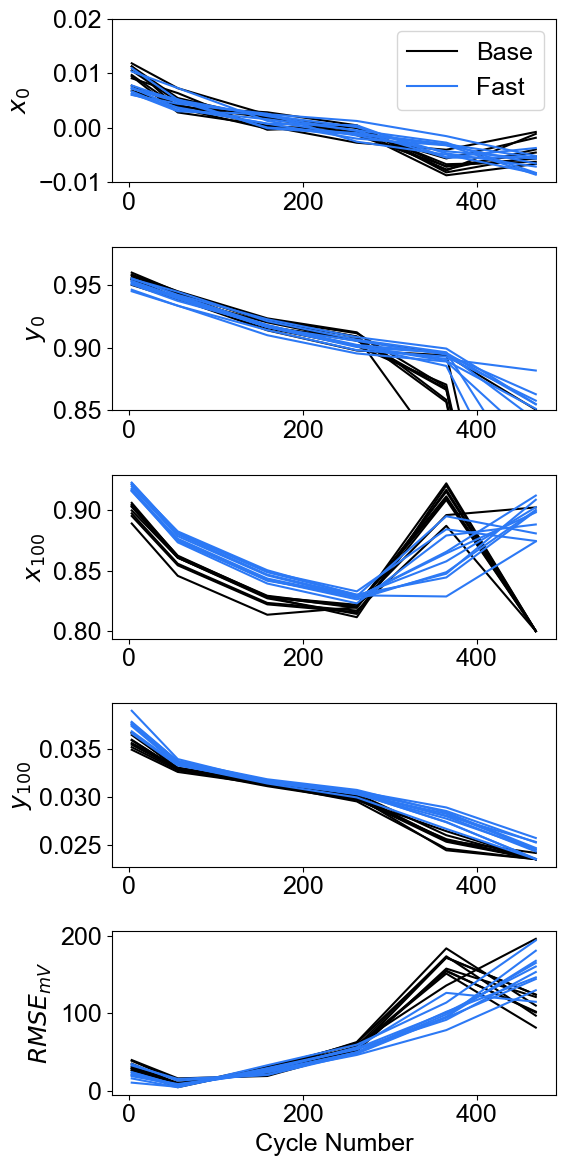

In [26]:
plt.figure(figsize=(6, 12))

ax1 = plt.subplot(511)
ax2 = plt.subplot(512)
ax3 = plt.subplot(513)
ax4 = plt.subplot(514)
ax5 = plt.subplot(515)

for cellid in cellid_list:
    
    cell = cell_dict[cellid]
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
    else:
        color = COLOR_FAST
        
    esoh_data_list = cell_dict[cellid].get_esoh_fitting_data()

    cyc_number_list = [x['cycle_index'] for x in esoh_data_list]
    x_0_list = [x['x0'] for x in esoh_data_list]
    y_0_list = [x['y0'] for x in esoh_data_list]
    x_100_list = [x['x100'] for x in esoh_data_list]
    y_100_list = [x['y100'] for x in esoh_data_list]
    rmse_list = [x['RMSE_mV'] for x in esoh_data_list]
    
    ax1.plot(cyc_number_list, x_0_list, color=color)
    ax1.set_ylabel('$x_0$')
    ax1.set_ylim((-0.01, 0.02))

    ax2.plot(cyc_number_list, y_0_list, color=color)
    ax2.set_ylabel('$y_0$')
    ax2.set_ylim((0.85, 0.98))

    ax3.plot(cyc_number_list, x_100_list, color=color)
    ax3.set_ylabel('$x_{100}$')

    ax4.plot(cyc_number_list, y_100_list, color=color)
    ax4.set_ylabel('$y_{100}$')

    ax5.plot(cyc_number_list, rmse_list, color=color)
    ax5.set_ylabel('$RMSE_{mV}$')
    ax5.set_xlabel('Cycle Number')

ax1.plot(np.nan, np.nan, color=COLOR_BASE, label='Base')
ax1.plot(np.nan, np.nan, color=COLOR_FAST, label='Fast')

ax1.legend()
    

Prepare the two datasets for comparison

Compare the same cell, two aging conditions

In [27]:
esoh_data_1 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]
esoh_data_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[3]

print(f"Cycle {esoh_data_1['cycle_index']} to {esoh_data_2['cycle_index']}")
print(f"y0:   {esoh_data_1['y0']:.3f} --> {esoh_data_2['y0']:.3f}")
print(f"x0:   {esoh_data_1['x0']:.3f} --> {esoh_data_2['x0']:.3f}")
print(f"y100: {esoh_data_1['y100']:.3f} --> {esoh_data_2['y100']:.3f}")
print(f"x100: {esoh_data_1['x100']:.3f} --> {esoh_data_2['x100']:.3f}")
print(f"---")
print(f"LAM_PE = {100 - 100 * esoh_data_2['Cp'] / esoh_data_1['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_2['Cn'] / esoh_data_1['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_1['n_li'] - esoh_data_2['n_li']) / esoh_data_1['n_li'] :.1f}%")

Cycle 3.0 to 262.0
y0:   0.950 --> 0.902
x0:   0.007 --> -0.001
y100: 0.038 --> 0.031
x100: 0.922 --> 0.829
---
LAM_PE = 5.8%
LAM_NE = 0.9%
LLI = 11.3%


Here is another dataset for comparison

Compare a baseline vs fast formation cell, both fresh

In [28]:
esoh_data_1 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
esoh_data_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]

print(f"       Base --> Fast")
print(f"y0:   {esoh_data_1['y0']:.3f} --> {esoh_data_2['y0']:.3f}")
print(f"x0:   {esoh_data_1['x0']:.3f} --> {esoh_data_2['x0']:.3f}")
print(f"y100: {esoh_data_1['y100']:.3f} --> {esoh_data_2['y100']:.3f}")
print(f"x100: {esoh_data_1['x100']:.3f} --> {esoh_data_2['x100']:.3f}")
print(f"---")
print(f"LAM_PE = {100 - 100 * esoh_data_2['Cp'] / esoh_data_1['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_2['Cn'] / esoh_data_1['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_1['n_li'] - esoh_data_2['n_li']) / esoh_data_1['n_li'] :.1f}%")

       Base --> Fast
y0:   0.954 --> 0.950
x0:   0.009 --> 0.007
y100: 0.037 --> 0.038
x100: 0.905 --> 0.922
---
LAM_PE = 0.2%
LAM_NE = 2.8%
LLI = 0.8%


### Available keys

In [29]:
xlim_array = [(-0.3, 3), 
              (-0.3, 0.3),
              (2.0, 2.6)]

neg_ylim_array = [(-0.05, 1.05),
                  (-0.05, 1.05),
                  (0.08, 0.095)]

pos_ylim_array = [(2.4, 4.55), 
                  (2.95, 3.75),
                  (4.10, 4.39)]

Text(0, 0.5, 'dV/dQ (V/Ah)')

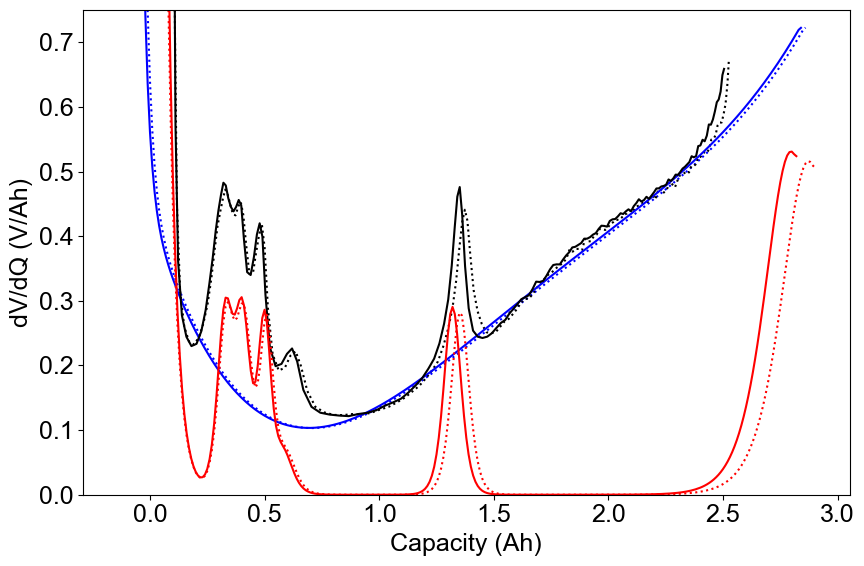

In [30]:
# dV/dQ
fig, ax = plt.subplots(figsize=(9,6))
    
plt.plot(esoh_data_1['pos']['Q'], esoh_data_1['pos']['dVdQ'], color=COLOR_POS, linestyle=':')
plt.plot(esoh_data_1['orig']['Q'], esoh_data_1['orig']['dVdQ'], color=COLOR_FULL_CELL, linestyle=':')
plt.plot(esoh_data_2['pos']['Q'], esoh_data_2['pos']['dVdQ'], color=COLOR_POS)
plt.plot(esoh_data_2['orig']['Q'], esoh_data_2['orig']['dVdQ'], color=COLOR_FULL_CELL)
plt.plot(esoh_data_1['neg']['Q'], esoh_data_1['neg']['dVdQ'], color=COLOR_NEG, linestyle=':')
plt.plot(esoh_data_2['neg']['Q'], esoh_data_2['neg']['dVdQ'], color=COLOR_NEG)

plt.ylim((0, 0.75))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (V/Ah)')

In [31]:
esoh_data_1 = cell_dict[CELL_FAST].get_esoh_fitting_data()[0]
esoh_data_2 = cell_dict[CELL_FAST].get_esoh_fitting_data()[3]
esoh_data_3 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0]
esoh_data_4 = cell_dict[CELL_BASE].get_esoh_fitting_data()[3]

print(f"       Base --> Fast  --> Fast (aged)")
print(f"y0:   {esoh_data_3['y0']:.3f} --> {esoh_data_1['y0']:.3f} --> {esoh_data_2['y0']:.3f}")
print(f"x0:   {esoh_data_3['x0']:.3f} --> {esoh_data_1['x0']:.3f} --> {esoh_data_2['x0']:.3f}")
print(f"y100: {esoh_data_3['y100']:.3f} --> {esoh_data_1['y100']:.3f} --> {esoh_data_2['y100']:.3f}")
print(f"x100: {esoh_data_3['x100']:.3f} --> {esoh_data_1['x100']:.3f} --> {esoh_data_2['x100']:.3f}")
print(f"---")
print(f"Fast --> Fast (aged)")
print(f"LAM_PE = {100 - 100 * esoh_data_2['Cp'] / esoh_data_1['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_2['Cn'] / esoh_data_1['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_1['n_li'] - esoh_data_2['n_li']) / esoh_data_1['n_li'] :.1f}%")
print(f"---")
print(f"Base --> Fast")
print(f"LAM_PE = {100 - 100 * esoh_data_1['Cp'] / esoh_data_3['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_1['Cn'] / esoh_data_3['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_3['n_li'] - esoh_data_1['n_li']) / esoh_data_3['n_li'] :.1f}%")
print(f"Base --> Base (aged)")
print(f"LAM_PE = {100 - 100 * esoh_data_4['Cp'] / esoh_data_3['Cp']:.1f}%")
print(f"LAM_NE = {100 - 100 * esoh_data_4['Cn'] / esoh_data_3['Cn']:.1f}%")
print(f"LLI = {100 * (esoh_data_3['n_li'] - esoh_data_4['n_li']) / esoh_data_3['n_li'] :.1f}%")


       Base --> Fast  --> Fast (aged)
y0:   0.954 --> 0.950 --> 0.902
x0:   0.009 --> 0.007 --> -0.001
y100: 0.037 --> 0.038 --> 0.031
x100: 0.905 --> 0.922 --> 0.829
---
Fast --> Fast (aged)
LAM_PE = 5.8%
LAM_NE = 0.9%
LLI = 11.3%
---
Base --> Fast
LAM_PE = 0.2%
LAM_NE = 2.8%
LLI = 0.8%
Base --> Base (aged)
LAM_PE = 6.4%
LAM_NE = 2.4%
LLI = 12.0%


/Users/aweng/.pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/matplotlib/lines.py:1171: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  or np.any(self._markeredgecolor != ec)):


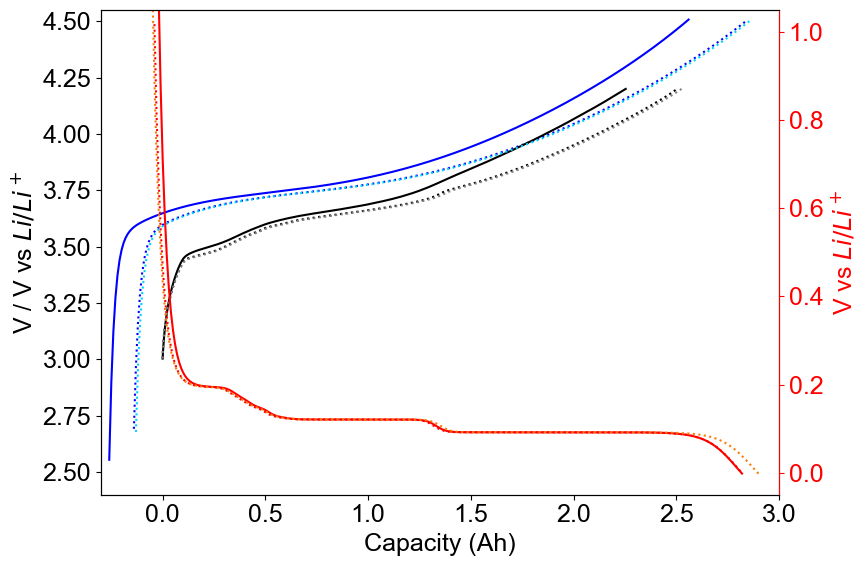

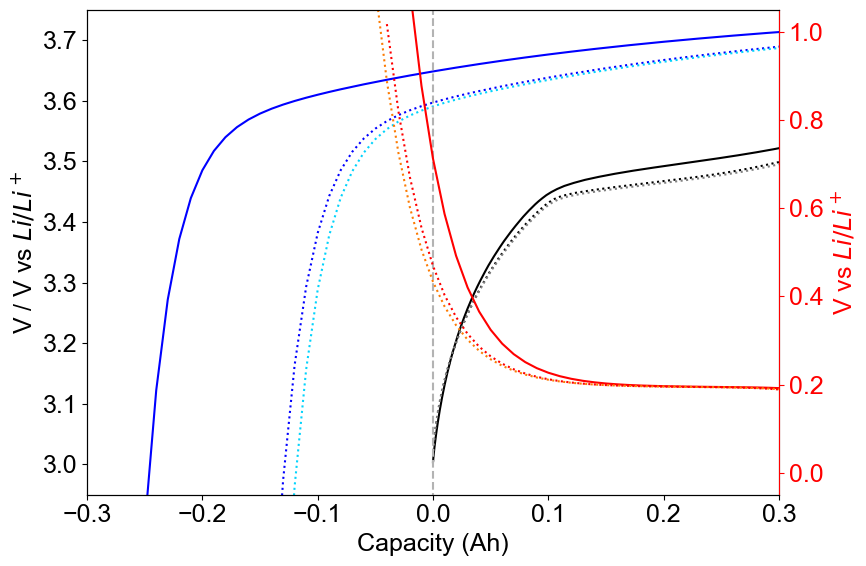

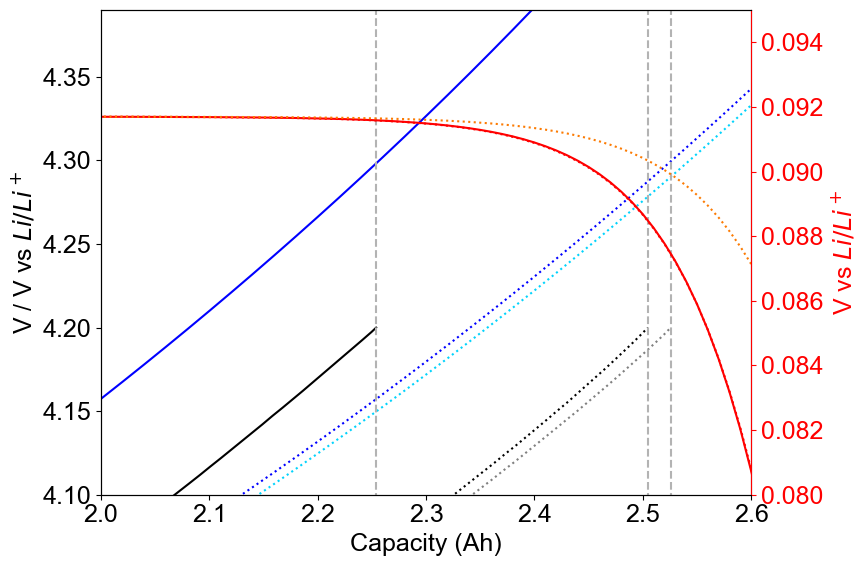

In [32]:
fig_arr, ax_arr, ax2_arr = [], [], []

for (xlim, neg_ylim, pos_ylim) in zip(xlim_array, neg_ylim_array, pos_ylim_array):

    fig, ax = plt.subplots(figsize=(9,6))
    ax2 = ax.twinx()
    
    fig_arr.append(fig)
    ax_arr.append(ax)
    ax2_arr.append(ax2)
    
    ax.plot(esoh_data_1['pos']['Q'], esoh_data_1['pos']['V'], color=COLOR_POS, linestyle=':')
    ax.plot(esoh_data_1['orig']['Q'], esoh_data_1['orig']['V'], color=COLOR_FULL_CELL, linestyle=':')
    ax2.plot(esoh_data_1['neg']['Q'], esoh_data_1['neg']['V'], color=COLOR_NEG, linestyle=':')
    
    ax.plot(esoh_data_2['pos']['Q'], esoh_data_2['pos']['V'], color=COLOR_POS)
    ax.plot(esoh_data_2['orig']['Q'], esoh_data_2['orig']['V'], color=COLOR_FULL_CELL)
    ax2.plot(esoh_data_2['neg']['Q'], esoh_data_2['neg']['V'], color=COLOR_NEG)

    ax.plot(esoh_data_3['pos']['Q'], esoh_data_3['pos']['V'], color=np.array([3, 211, 252])/255, linestyle=':')
    ax.plot(esoh_data_3['orig']['Q'], esoh_data_3['orig']['V'], color=np.array([0.5, 0.5, 0.5]), linestyle=':')
    ax2.plot(esoh_data_3['neg']['Q'], esoh_data_3['neg']['V'], color=np.array([252, 123, 3])/255, linestyle=':')
    
#     ax.plot(esoh_data_4['pos']['Q'], esoh_data_4['pos']['V'], color=np.array([3, 211, 252])/255, linestyle='-')
#     ax.plot(esoh_data_4['orig']['Q'], esoh_data_4['orig']['V'], color=np.array([0.5, 0.5, 0.5]), linestyle='-')
#     ax2.plot(esoh_data_4['neg']['Q'], esoh_data_4['neg']['V'], color=np.array([252, 123, 3])/255, linestyle='-')
    
    ax.set_xlabel('Capacity (Ah)')
    ax2.yaxis.label.set_color(COLOR_NEG)
    ax2.spines["right"].set_edgecolor(COLOR_NEG)
    ax2.tick_params(axis='y', colors=COLOR_NEG)

    ax.set_ylabel('V / V vs $Li/Li^+$')
    ax2.set_ylabel('V vs $Li/Li^+$')
    ax.set_xlim(xlim)
    ax2.set_ylim(neg_ylim)
    ax.set_ylim(pos_ylim)

ax_arr[1].plot([0, 0], [0, 5], color=COLOR_REF, linestyle='--')

ax_arr[2].plot([esoh_data_1['orig']['Q'][-1], esoh_data_1['orig']['Q'][-1]], 
               [0, 5], color=COLOR_REF, linestyle='--')
ax_arr[2].plot([esoh_data_2['orig']['Q'][-1], esoh_data_2['orig']['Q'][-1]], 
               [0, 5], color=COLOR_REF, linestyle='--')
ax_arr[2].plot([esoh_data_3['orig']['Q'][-1], esoh_data_3['orig']['Q'][-1]], 
               [0, 5], color=COLOR_REF, linestyle='--')
# ax_arr[2].plot([esoh_data_4['orig']['Q'][-1], esoh_data_4['orig']['Q'][-1]], 
#                [0, 5], color=COLOR_REF, linestyle='--')

Text(0, 0.5, 'dV/dQ (V/Ah)')

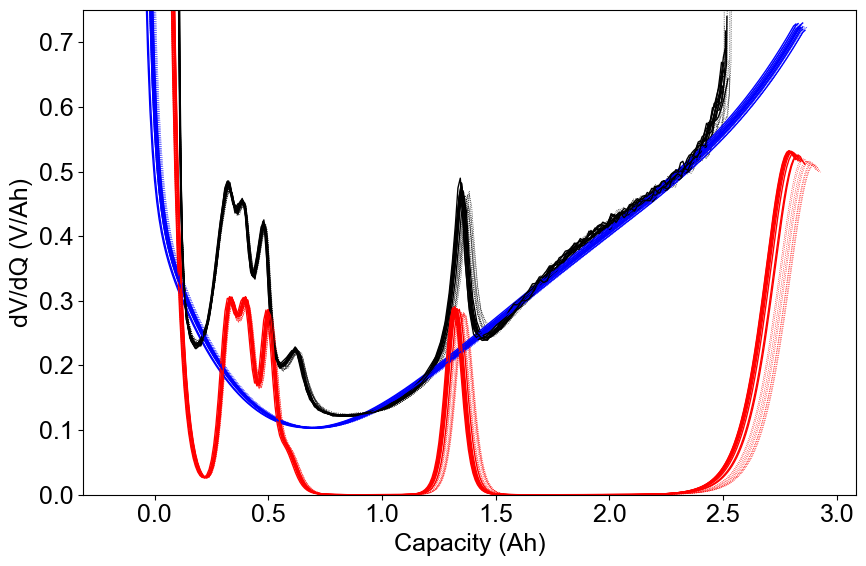

In [33]:
# dV/dQ
fig, ax = plt.subplots(figsize=(9,6))

for cellid in cellid_list:
    
    cell = cell_dict[cellid]
    
    if cell.is_room_temp() or cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        linestyle = ':'
        linewidth = 0.5
    else:
        linestyle = '-'
        linewidth = 1
        
    esoh_data = cell.get_esoh_fitting_data()[0]
    assert esoh_data['cycle_index'] == 3
        
    plt.plot(esoh_data['pos']['Q'], esoh_data['pos']['dVdQ'], 
             color=COLOR_POS, linestyle=linestyle, linewidth=linewidth)
    plt.plot(esoh_data['orig']['Q'], esoh_data['orig']['dVdQ'], 
             color=COLOR_FULL_CELL, linestyle=linestyle, linewidth=linewidth)
    plt.plot(esoh_data['neg']['Q'], esoh_data['neg']['dVdQ'], 
             color=COLOR_NEG, linestyle=linestyle, linewidth=linewidth)

plt.ylim((0, 0.75))
plt.xlabel('Capacity (Ah)')
plt.ylabel('dV/dQ (V/Ah)')

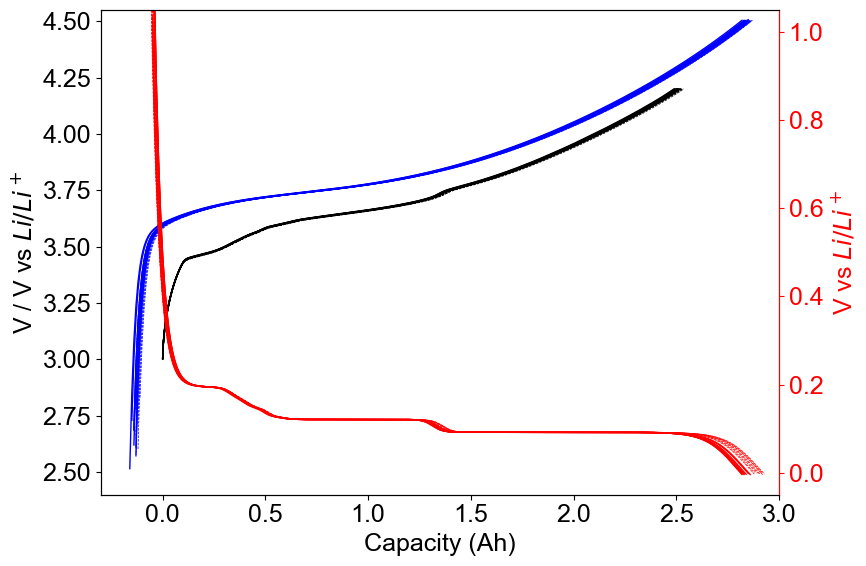

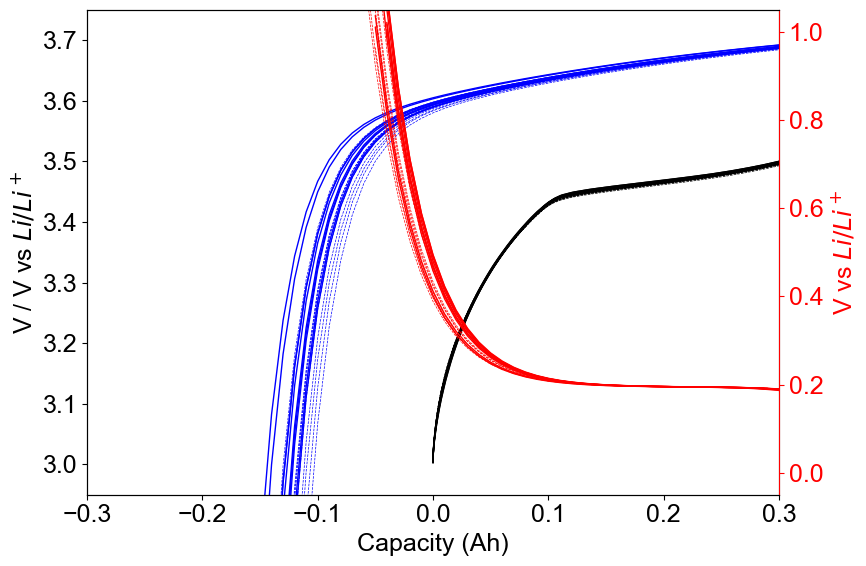

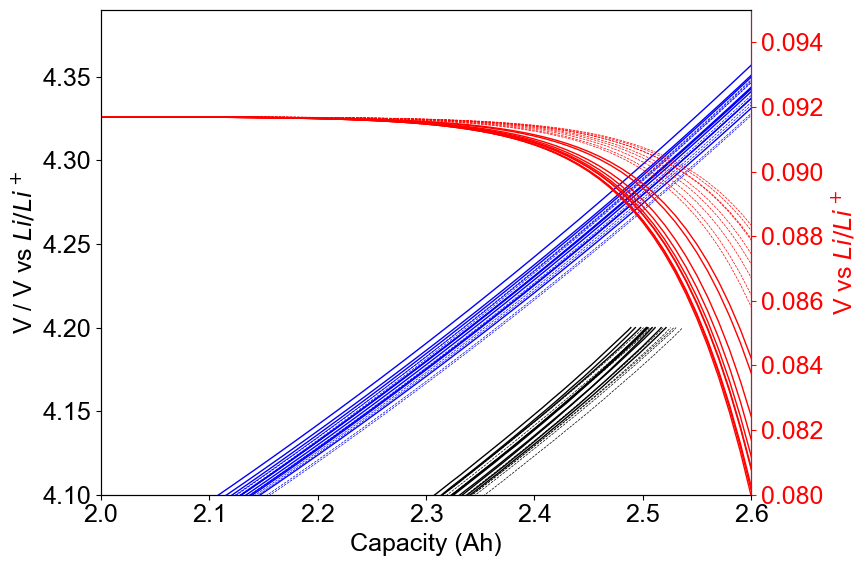

In [34]:
fig_arr, ax_arr, ax2_arr = [], [], []

for (xlim, neg_ylim, pos_ylim) in zip(xlim_array, neg_ylim_array, pos_ylim_array):

    fig, ax = plt.subplots(figsize=(9,6))
    ax2 = ax.twinx()
    
    fig_arr.append(fig)
    ax_arr.append(ax)
    ax2_arr.append(ax2)
    
    for cellid in cellid_list:
        
        cell = cell_dict[cellid]

        if cell.is_room_temp() or cell.cellid == 9:
            continue
            
        if cell.is_baseline_formation():
            linestyle = '--'
            linewidth = 0.5
        else:
            linestyle = '-'
            linewidth = 1

        esoh_data = cell.get_esoh_fitting_data()[0]
        assert esoh_data['cycle_index'] == 3        

        ax.plot(esoh_data['pos']['Q'], esoh_data['pos']['V'], 
                color=COLOR_POS, linestyle=linestyle, linewidth=linewidth)
        ax.plot(esoh_data['orig']['Q'], esoh_data['orig']['V'], 
                color=COLOR_FULL_CELL, linestyle=linestyle, linewidth=linewidth)
        ax2.plot(esoh_data['neg']['Q'], esoh_data['neg']['V'], 
                 color=COLOR_NEG, linestyle=linestyle, linewidth=linewidth)

        ax.set_xlabel('Capacity (Ah)')
        ax2.yaxis.label.set_color(COLOR_NEG)
        ax2.spines["right"].set_edgecolor(COLOR_NEG)
        ax2.tick_params(axis='y', colors=COLOR_NEG)

        ax.set_ylabel('V / V vs $Li/Li^+$')
        ax2.set_ylabel('V vs $Li/Li^+$')
        ax.set_xlim(xlim)
        ax2.set_ylim(neg_ylim)
        ax.set_ylim(pos_ylim)

Comparison of metrics

In [35]:
df = pd.DataFrame([esoh_data_1, esoh_data_2], index=['1', '2'])
df = df.drop(columns=['ful', 'pos', 'neg', 'orig', 'Xt'])
# df = df.transpose()
df

np_ratio        Cp        Cn      y100        y0        x0      x100  \
1  0.998022  2.739773  2.734355  0.037883  0.950368  0.007241  0.921533   
2  1.049460  2.582096  2.709805  0.030757  0.902142 -0.001215  0.829103   

       n_li  Cn_excess  Cp_excess    Cf    RMSE_mV     Cn_pf   x100_pf  \
1  0.097890       0.32       0.14  2.50  21.222650  2.856612  0.889973   
2  0.086791       0.57       0.26  2.25  49.961065  2.661899  0.832379   

   cycle_index  
1          3.0  
2        262.0

Percentage changes:

In [36]:
df.pct_change(axis='rows')*100

np_ratio        Cp        Cn      y100        y0         x0       x100  \
1       NaN       NaN       NaN       NaN       NaN        NaN        NaN   
2  5.153919 -5.755137 -0.897833 -18.81156 -5.074402 -116.77793 -10.030008   

        n_li  Cn_excess  Cp_excess    Cf     RMSE_mV     Cn_pf   x100_pf  \
1        NaN        NaN        NaN   NaN         NaN       NaN       NaN   
2 -11.338089     78.125  85.714286 -10.0  135.413881 -6.816221 -6.471471   

   cycle_index  
1          NaN  
2  8633.333333

# Plot the $\Delta Q$ metric

Processing cell 40...
Processing cell 1...
Processing cell 2...
Processing cell 3...
Processing cell 4...
Processing cell 5...
Processing cell 6...
Processing cell 7...
Processing cell 8...
Processing cell 9...
Processing cell 10...
Processing cell 11...
Processing cell 12...
Processing cell 13...
Processing cell 14...
Processing cell 15...
Processing cell 16...
Processing cell 17...
Processing cell 18...
Processing cell 19...
Processing cell 20...
Processing cell 21...
Processing cell 22...
Processing cell 23...
Processing cell 24...
Processing cell 25...
Processing cell 26...
Processing cell 27...
Processing cell 28...
Processing cell 29...
Processing cell 30...
Processing cell 31...
Processing cell 32...
Processing cell 33...
Processing cell 34...
Processing cell 35...
Processing cell 36...
Processing cell 37...
Processing cell 38...
Processing cell 39...


Text(0.5, 1.0, '45C')

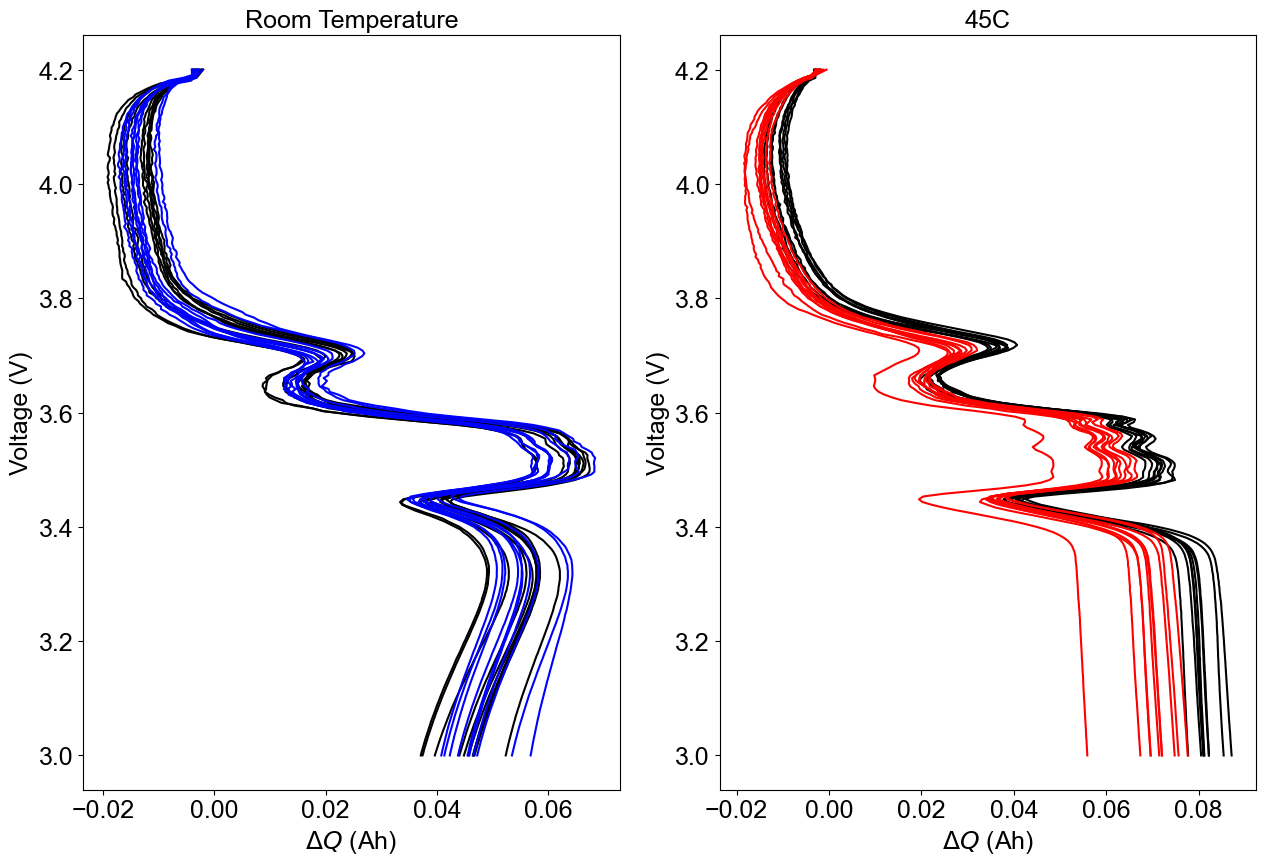

In [37]:
plt.figure(figsize=(13, 9))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for cellid in cellid_list:
    
    print(f'Processing cell {cell.cellid}...')
    
    cell = cell_dict[cellid]
    
    if cell.cellid == 9:
        continue
        
    if cell.is_baseline_formation():
        color = COLOR_BASE
    else: 
        if cell.is_room_temp():
            color = COLOR_FAST_RT
        else: 
            color = COLOR_FAST_HT
            
    if cell.is_room_temp():
        ax = ax1
    else:
        ax = ax2
        
    res = cell.calculate_var_q_c20_discharge()
    
    ax.plot(res['var_q_c20_c56_c3_delta_q'], res['var_q_c20_c56_c3_voltage_v'], color=color)

ax1.set_ylabel('Voltage (V)')
ax1.set_xlabel('$\Delta Q$ (Ah)')
ax2.set_ylabel('Voltage (V)')
ax2.set_xlabel('$\Delta Q$ (Ah)')
ax1.set_title('Room Temperature')
ax2.set_title('45C')

In [38]:
res

{'var_q_c20_c56_c3_ah': 0.0012528998536859657,
 'var_q_c20_c56_c3_delta_q': array([-0.00264326, -0.00315737, -0.00367149, -0.0041856 , -0.00598098,
        -0.00712456, -0.00790045, -0.00884785, -0.00937398, -0.01001439,
        -0.01058502, -0.01115964, -0.0114773 , -0.01163937, -0.01208533,
        -0.01248971, -0.0127824 , -0.01319749, -0.01322845, -0.01339451,
        -0.01370959, -0.01400764, -0.01418363, -0.01402495, -0.01437261,
        -0.01437726, -0.01440115, -0.01432041, -0.01462477, -0.01470352,
        -0.0145823 , -0.01453155, -0.01454196, -0.01462474, -0.01448577,
        -0.01447331, -0.01448406, -0.01446482, -0.01460317, -0.01438288,
        -0.01415879, -0.01413983, -0.01391916, -0.01403879, -0.01385322,
        -0.01396628, -0.01346544, -0.01354365, -0.01334308, -0.01325497,
        -0.01297254, -0.01280661, -0.01269396, -0.0124307 , -0.0124013 ,
        -0.01216305, -0.01194749, -0.01165861, -0.01128918, -0.01126865,
        -0.0111346 , -0.01074994, -0.0104982 , -0